In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score 
import requests
import os

In [2]:
# load processed kenya data
kenya_data = pd.read_csv('/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/output/dbh_algorithm_evaluation_dataset.csv')

In [3]:
# load and processs pennsylvania data
folder = "/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/pennsylvania_data"
files = os.listdir(folder)
measurements = [file for file in files if len(file.split("_")) > 4]

In [4]:
measurements_1 = [file for file in measurements if 'S' not in file]
measurements_2 = [file for file in measurements if 'S' in file]

In [5]:
# extract tree_id and measurement number from filenames 
tree_id = [file.split("_")[3] for file in measurements_1]
tree_measurements = [file.split("_")[4] for file in measurements_1]

In [6]:
tree_measurments = pd.DataFrame({'tree_id': tree_id, 'tree_measurements': tree_measurements})

In [7]:
tree_id = [file.split("_")[3] for file in measurements_2]
selected_trees = pd.DataFrame({'tree_id': tree_id, 'selected_trees': measurements_2})

In [8]:
selected_trees = selected_trees.merge(tree_measurments, on='tree_id', how='left')

In [9]:
## run inference on the selected trees ##

# functions to get dbh estimation for an image. The dbh estimation algorithm FastAPI must be running locally. 

def getDBH(temp_image, measured_dbh):
    try:

        url = f'http://127.0.0.1:8000/recognize/{measured_dbh}'

        file = {'uploaded_file': open(temp_image, 'rb')}

        r = requests.post(url, files=file)

        dbh = eval(r.text)['dbh']

        return dbh
        
    except:
        return None

In [10]:
selected_trees['filepath'] = selected_trees['selected_trees'].apply(lambda x: f'{folder}/{x}')

In [11]:
selected_trees['predicted_dbh'] = selected_trees.apply(lambda x: getDBH(x['filepath'], x['tree_measurements']), axis=1)

In [12]:
def convertCircleToDiameter(circle):
    return circle / np.pi

In [13]:
selected_trees['measured_dbh'] = selected_trees['tree_measurements'].apply(lambda x: convertCircleToDiameter(float(x)))

In [14]:
kenya_data['source'] = 'kenya'
selected_trees['source'] = 'pennsylvania'

In [21]:
kenya_data[['tree_picture','source','measured_dbh','predicted_dbh']].head()

,tree_picture,source,measured_dbh,predicted_dbh
0,1675934772605.jpg,kenya,37.6,38.20
1,1675927458697.jpg,kenya,30.0,26.59
2,1675927603450.jpg,kenya,36.1,35.48
3,1675927823347.jpg,kenya,30.3,32.50
4,1675150159298.jpg,kenya,5.3,6.28


In [22]:
selected_trees['tree_picture'] = selected_trees['selected_trees']   
selected_trees[['tree_picture','source','measured_dbh', 'predicted_dbh']].head()

,tree_picture,source,measured_dbh,predicted_dbh
0,PXL_20231202_195313688_T33_S.jpg,pennsylvania,18.780283,19.32
1,PXL_20231202_191729943_T14_S.jpg,pennsylvania,14.101128,15.24
2,PXL_20231202_200513912_T38_S.jpg,pennsylvania,7.925916,7.07
3,PXL_20231202_194218655_T28_S.jpg,pennsylvania,15.915494,18.73
4,PXL_20231202_184117460_T1_S.jpg,pennsylvania,42.335215,42.22


In [23]:
combined_data = pd.concat([kenya_data[['tree_picture','source','measured_dbh','predicted_dbh']], selected_trees[['tree_picture','source','measured_dbh', 'predicted_dbh']]])

In [24]:
combined_data.to_csv('/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/output/combined_data.csv', index=False)

In [2]:
combined_data = pd.read_csv('/Users/edwardamoah/Documents/GitHub/pv_mrv/statistical_analysis/output/combined_data.csv')

In [3]:
def getRange(dbh):
    if dbh < 16:
        return "05.0-15.9"
    elif dbh < 26:
        return "16.0-25.9"
    elif dbh < 36:
        return "26.0-35.9"
    return "36+"

In [4]:
combined_data['dbh_range'] = combined_data['measured_dbh'].apply(lambda x: getRange(x))

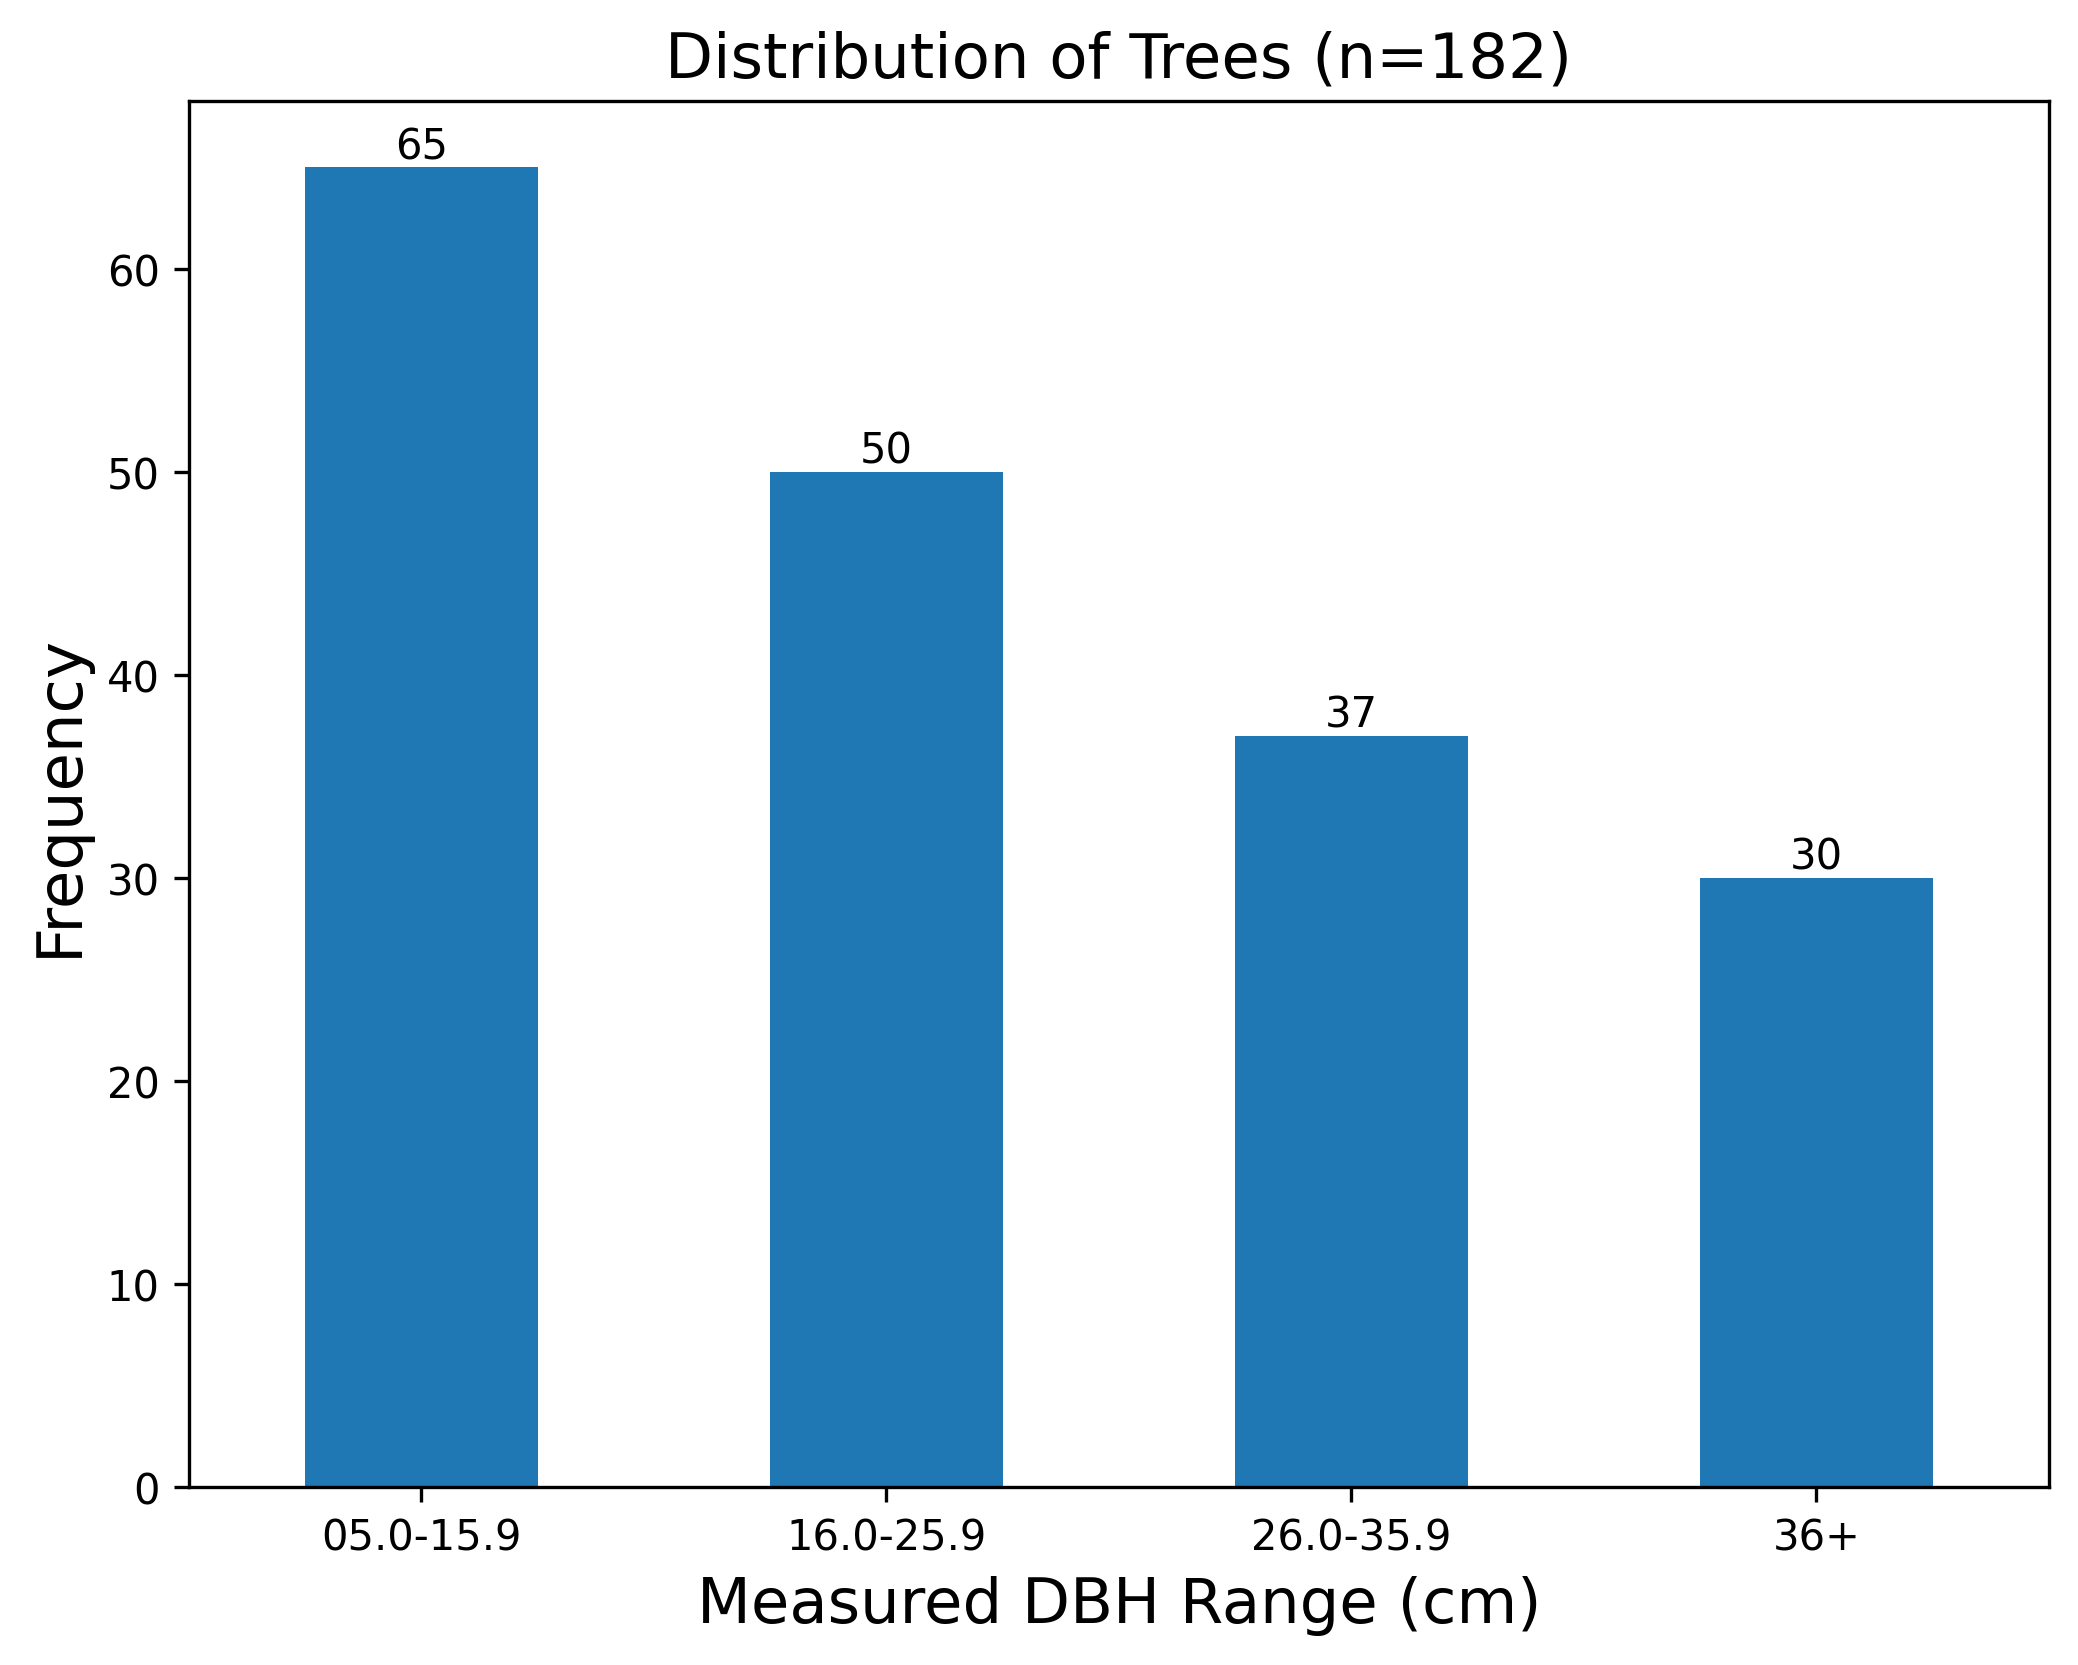

In [5]:
# Distribution of dataset
figure(figsize=(8, 6), dpi=300)
ax = combined_data.groupby('dbh_range').count()['measured_dbh'].plot.bar()
plt.title(f'Distribution of Trees (n={len(combined_data)})', size=15)
plt.xlabel("Measured DBH Range (cm)", size=15)
plt.ylabel("Frequency", size=15)
plt.xticks(rotation=0)

# Add sample number on bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')


In [6]:
def Bias(pred, obs):
    return pred - obs

def relBias(pred, obs):
    return ((pred-obs)/obs)*100

In [7]:
combined_data['bias'] = combined_data.apply(lambda x: Bias(x['predicted_dbh'], x['measured_dbh']), axis=1)
combined_data['rel_bias'] = combined_data.apply(lambda x: relBias(x['predicted_dbh'], x['measured_dbh']), axis=1)

Text(3, 6, 'B')

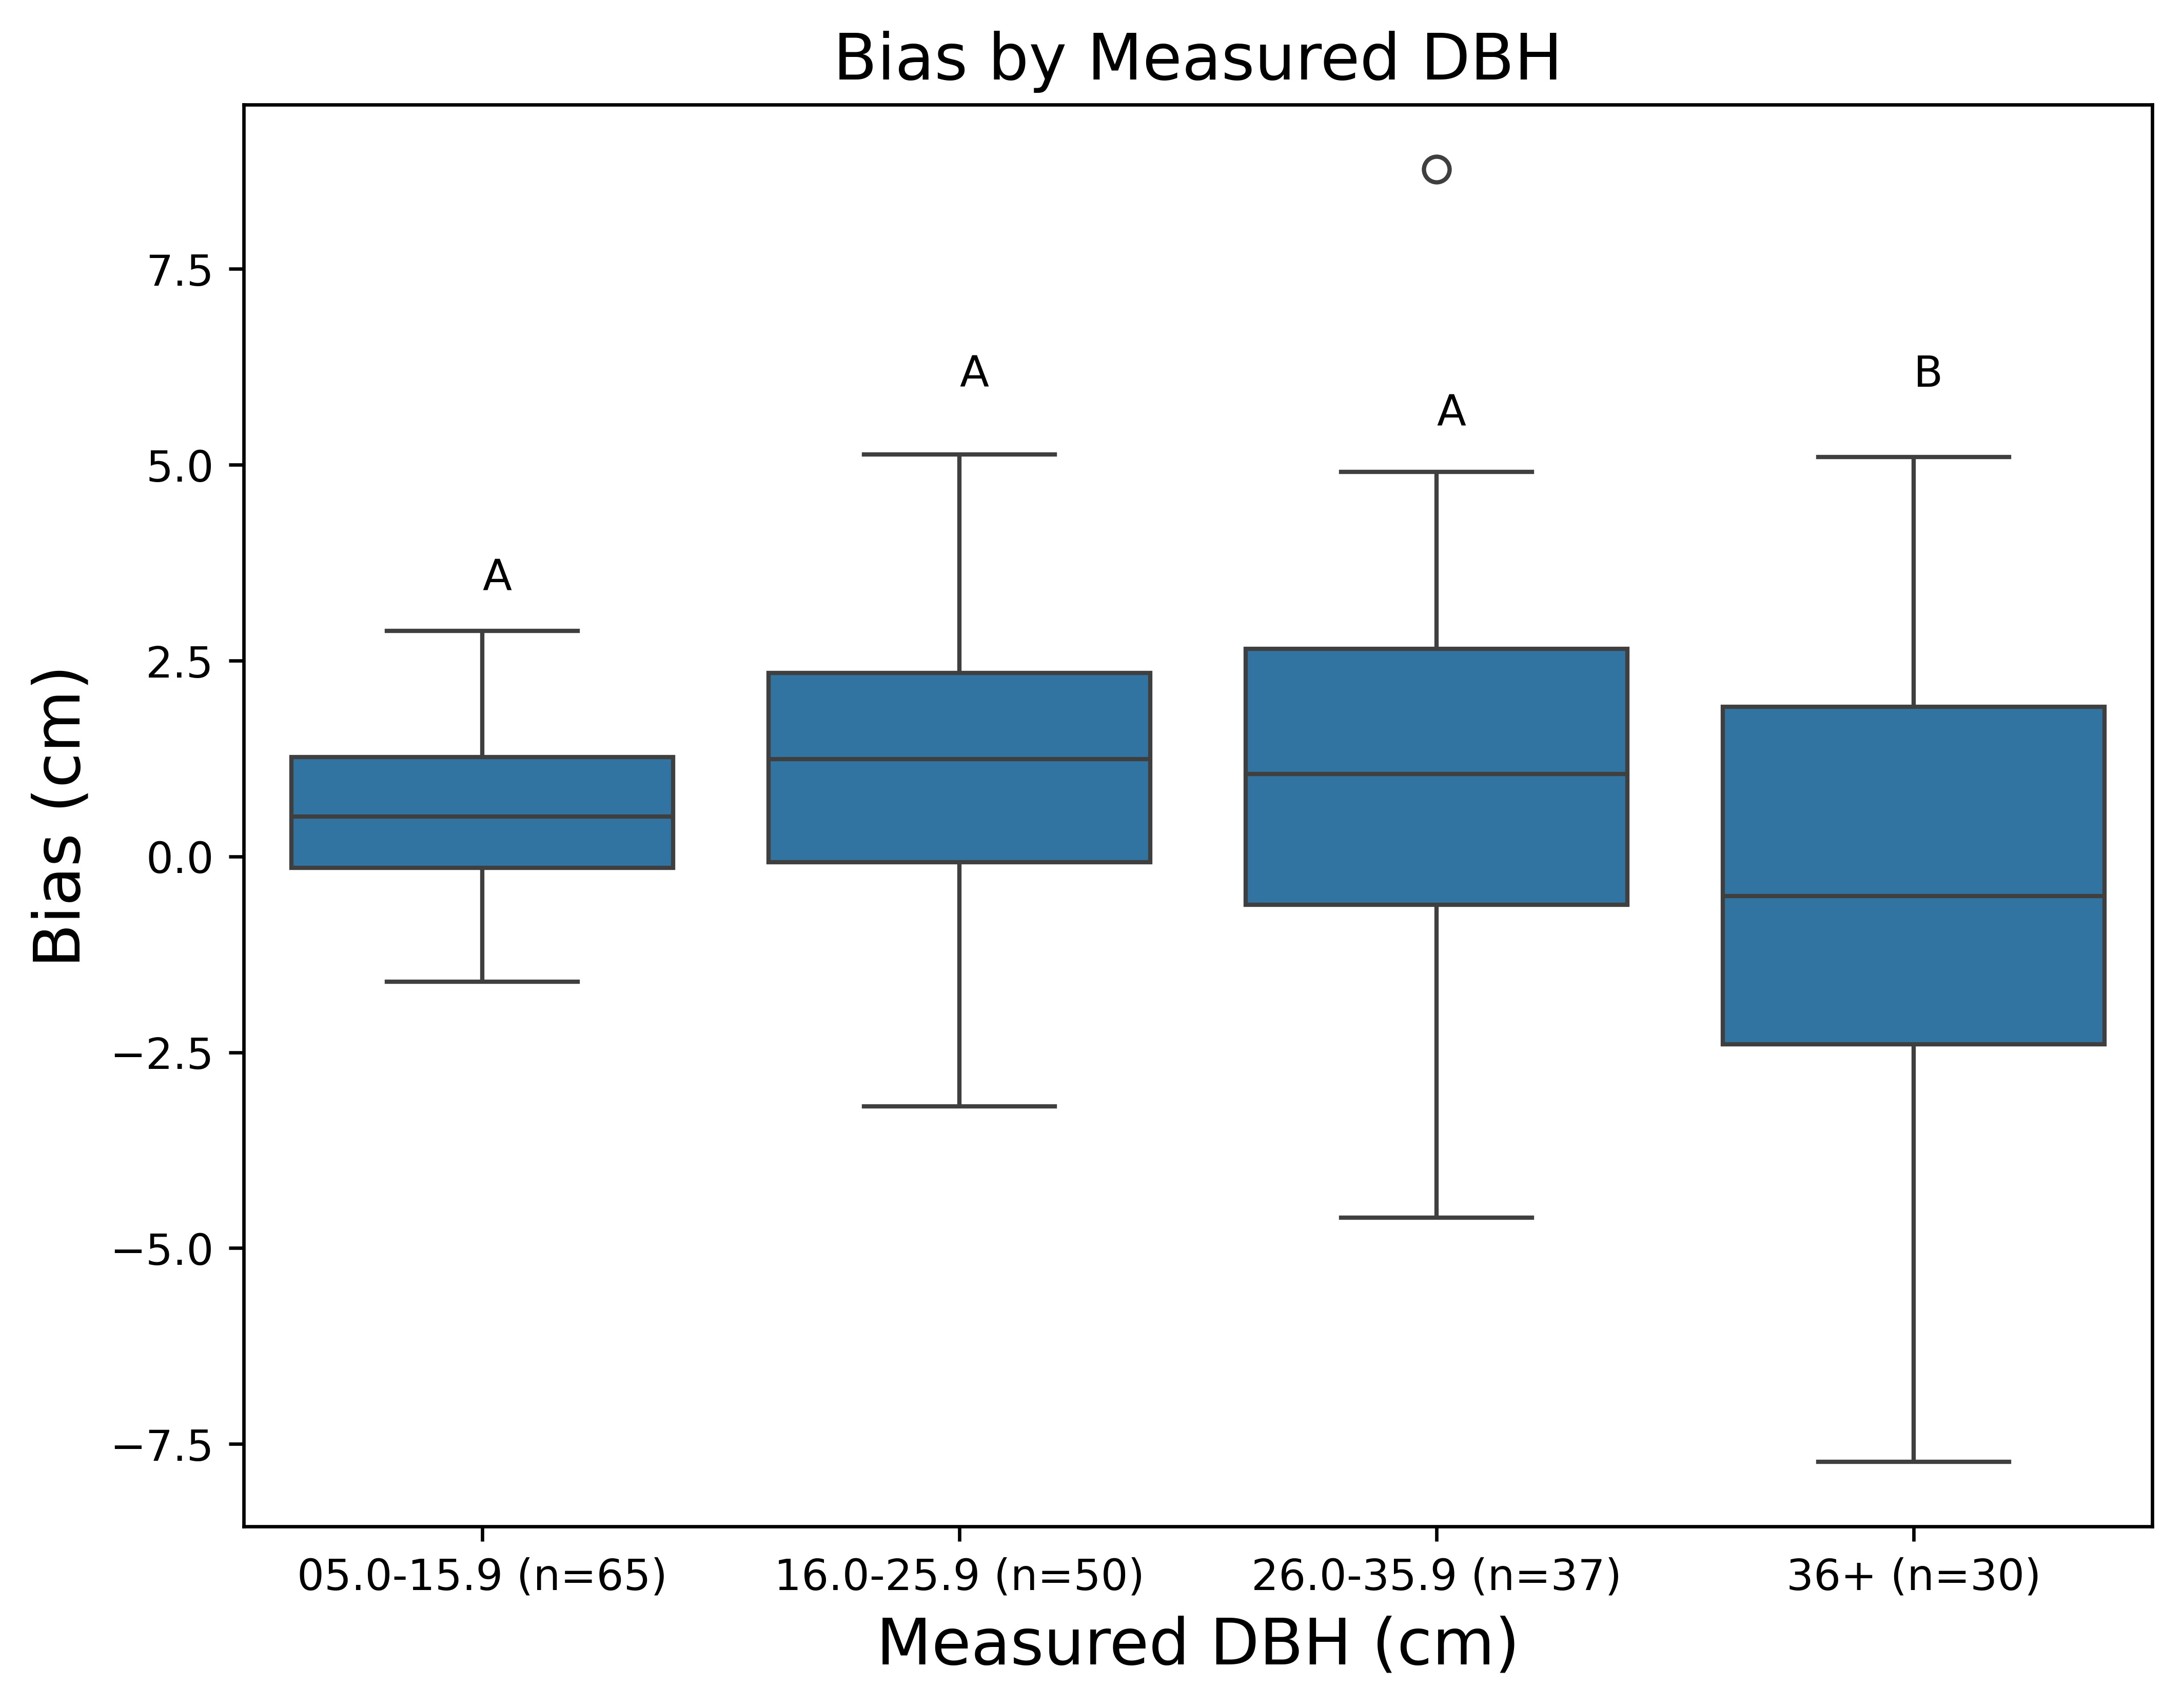

In [8]:
# Bias by Measured DBH
figure(figsize=(8, 6), dpi=600)
sns.boxplot(x="dbh_range", y="bias", data=combined_data, order=['05.0-15.9','16.0-25.9', '26.0-35.9', '36+'])
plt.xlabel("Measured DBH (cm)", size=15)
plt.ylabel("Bias (cm)", size=15)
plt.title("Bias by Measured DBH", size=15)

# add sample number to the boxplot

plt.xticks([0,1,2,3], [f'05.0-15.9 (n=65)','16.0-25.9 (n=50)', '26.0-35.9 (n=37)', '36+ (n=30)'])

# add text
plt.text(0, 3.4, "A")
plt.text(1, 6, "A")
plt.text(2, 5.5, "A")
plt.text(3, 6, "B")

([<matplotlib.axis.XTick at 0x14fc00bc0>,
 [Text(0, 0, '05.0-15.9 (n=65)'),
  Text(1, 0, '16.0-25.9 (n=50)'),
  Text(2, 0, '26.0-35.9 (n=37)'),
  Text(3, 0, '36+ (n=30)')])

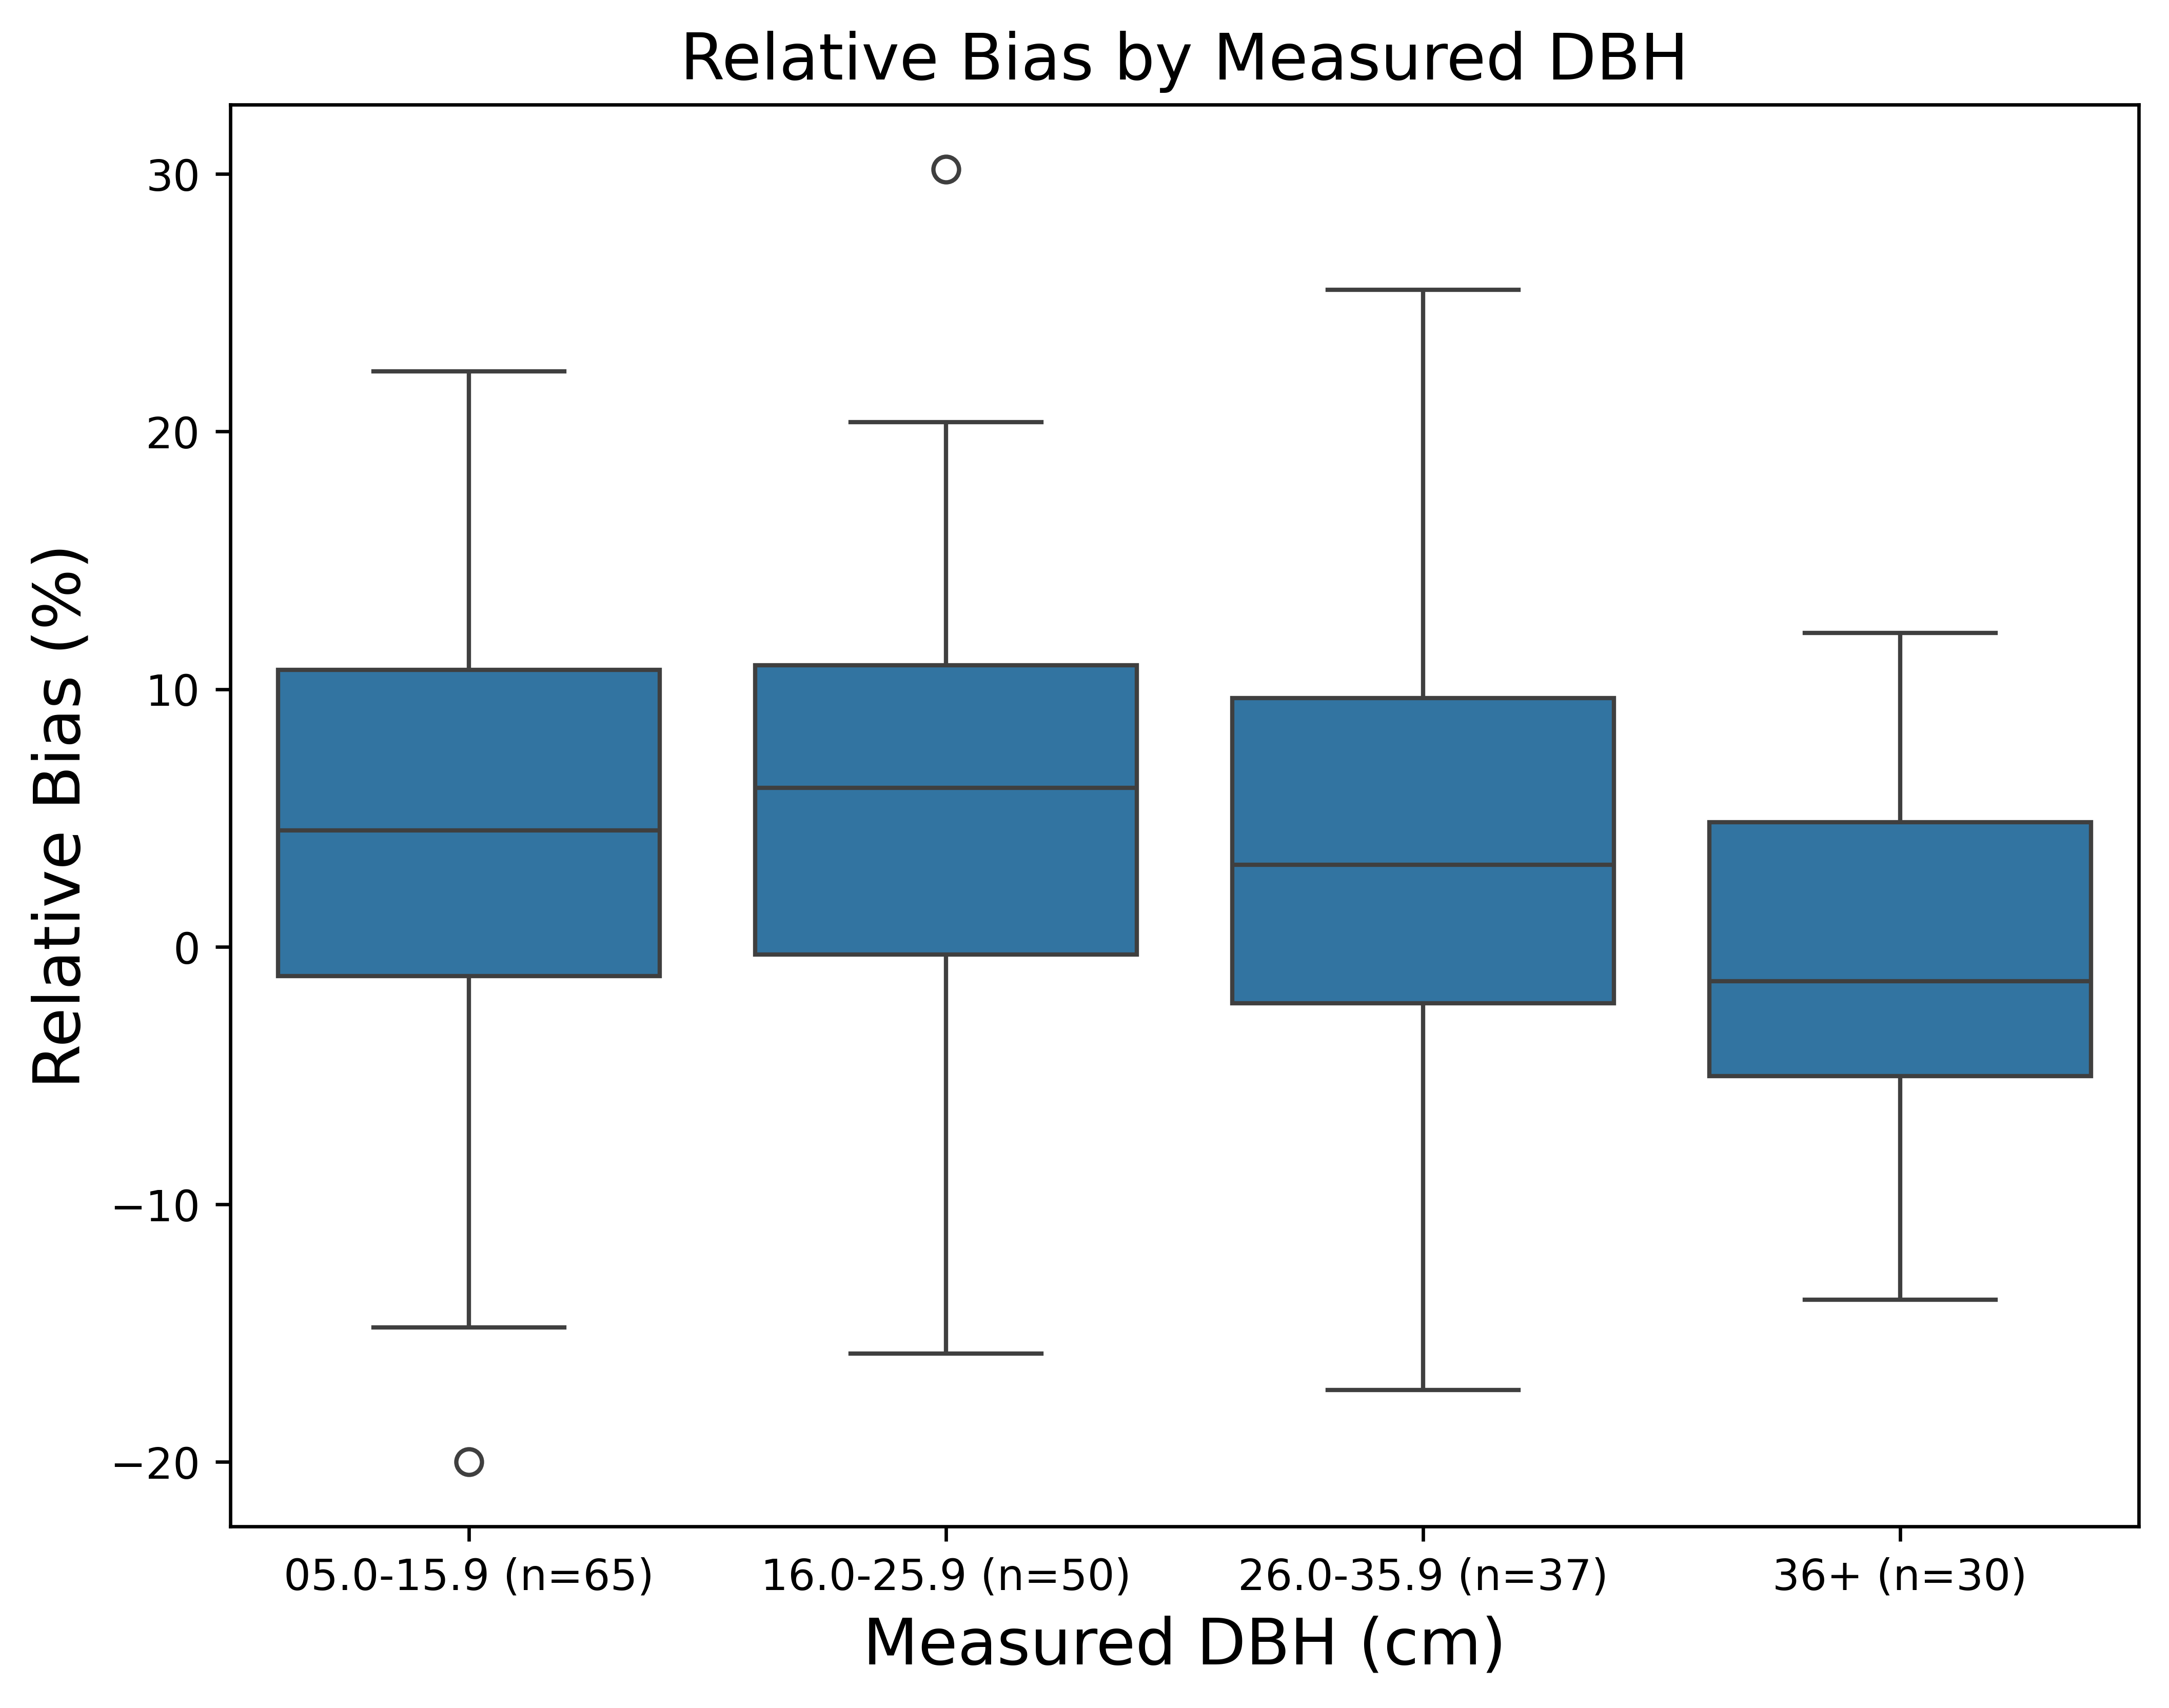

In [9]:
# plot relaive bias by measured dbh
figure(figsize=(8, 6), dpi=600)
sns.boxplot(x="dbh_range", y="rel_bias", data=combined_data, order=['05.0-15.9','16.0-25.9', '26.0-35.9', '36+'])
plt.xlabel("Measured DBH (cm)", size=15)
plt.ylabel("Relative Bias (%)", size=15)
plt.title("Relative Bias by Measured DBH", size=15)

# add sample number to the boxplot
plt.xticks([0,1,2,3], ['05.0-15.9 (n=65)','16.0-25.9 (n=50)', '26.0-35.9 (n=37)', '36+ (n=30)'])

In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np
actual = combined_data['measured_dbh']
predicted = combined_data['predicted_dbh']
rmse = np.sqrt(mean_squared_error(actual, predicted))
rmse


2.2266044269441143

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     5849.
Date:                Wed, 10 Sep 2025   Prob (F-statistic):          3.40e-139
Time:                        20:23:13   Log-Likelihood:                -392.64
No. Observations:                 182   AIC:                             789.3
Df Residuals:                     180   BIC:                             795.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3071      0.329      3.973      0.000       0.658       1.956
x1             0.9726      0.013     76.479      0.000       0.947       0.998
==============================================================================
Omnibus:                       10.783   Durbin-Watson:                   1.542
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.049
Skew:                          -0.057   Prob(JB):                     3.64e-06
Kurtosis:                       4.814   Cond. No.                         54.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

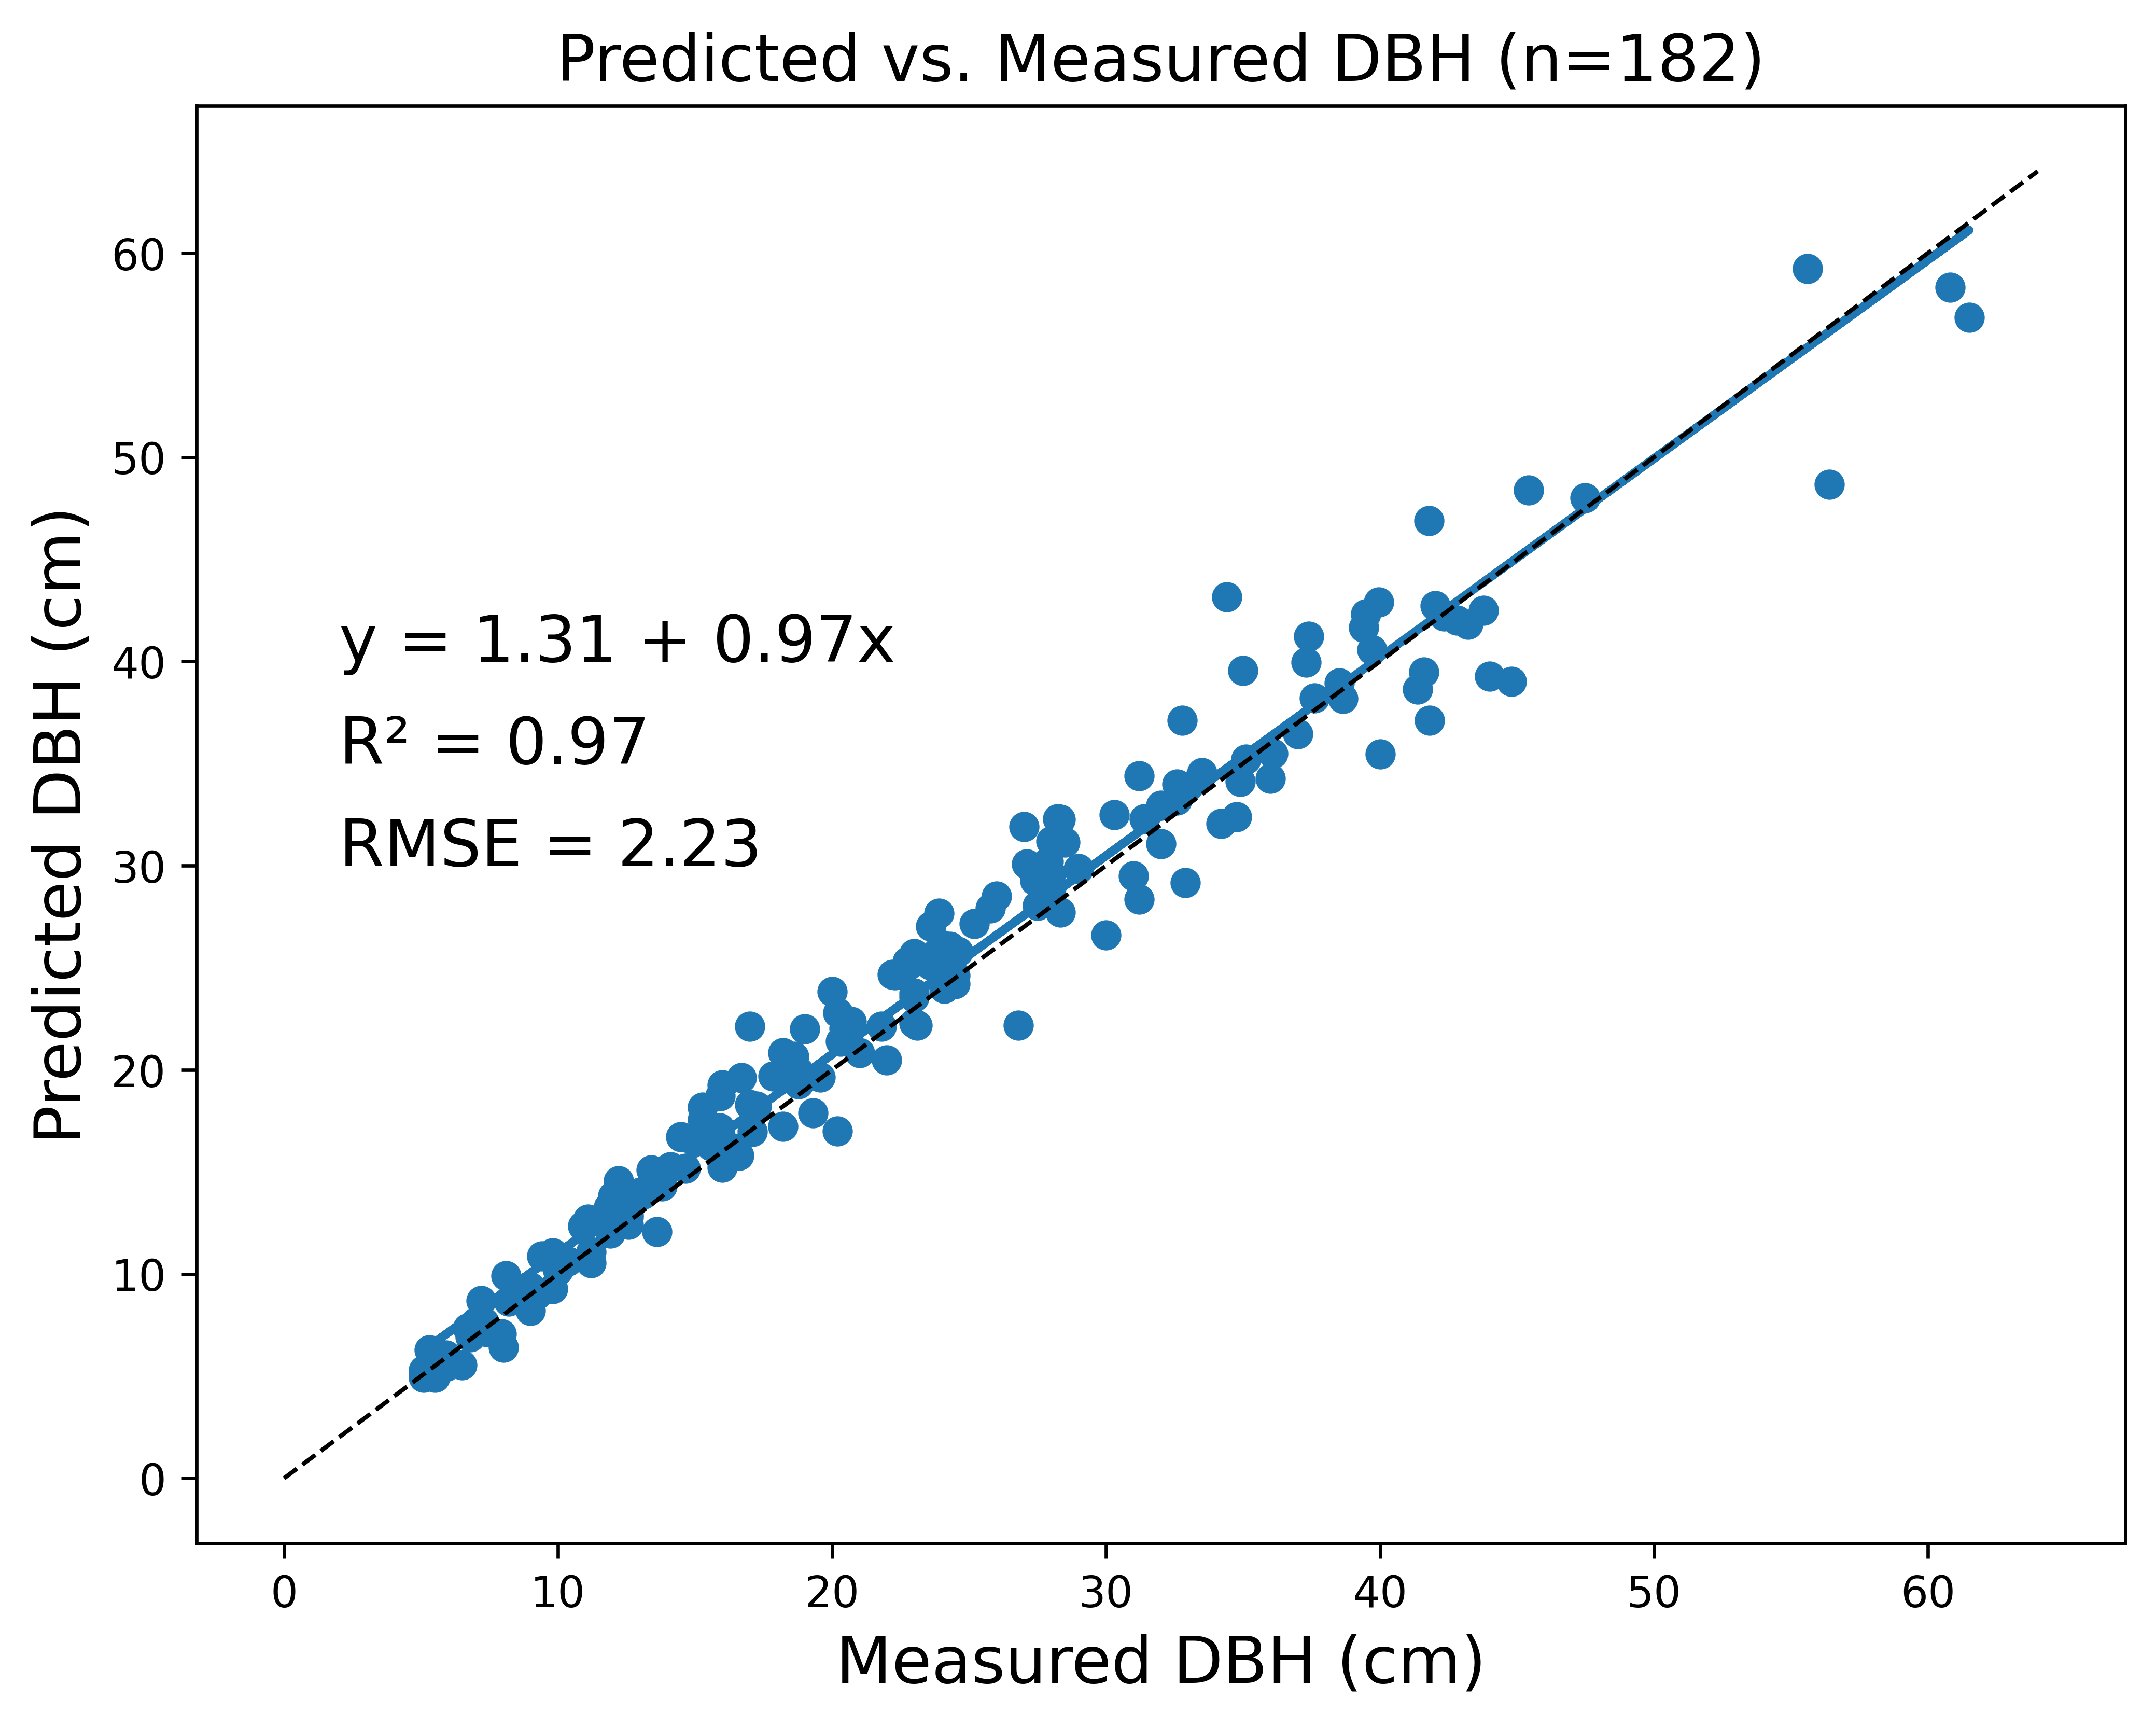

In [19]:
actual = combined_data['measured_dbh']
predicted = combined_data['predicted_dbh']
rmse = np.sqrt(mean_squared_error(actual, predicted))
rmse


# make residual plot for the corelation between predicted and measure dbh values
x = np.array(combined_data['measured_dbh']); y = np.array( [ float(x) for x in combined_data['predicted_dbh']])
a, b = np.polyfit(x, y , 1)

figure(figsize=(8, 6), dpi=600)


plt.scatter(x, y,)
plt.plot(x, a*x+b,  linewidth=2)
plt.plot(np.arange(65), np.arange(65), color='black', linestyle='--', linewidth=1)
plt.xlabel("Measured DBH (cm)",  size=15)
plt.ylabel("Predicted DBH (cm)",  size=15)
plt.title(f"Predicted vs. Measured DBH (n={len(combined_data)})", size=15)

# add fitted regression equation to plot
plt.text(2, 40, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=15)

# add the r2
plt.text(2,35, f"R\u00b2 = {round(r2_score(x,y),2)} ", size=15)

# add rmse
plt.text(2,30, f"RMSE = {round(rmse,2)} ", size=15)

# get the regression line and coefficients p value anc confidence interval
import statsmodels.api as sm
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
model.summary()

In [89]:
##### accuracy for just the kenya data #####

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4245.
Date:                Wed, 10 Sep 2025   Prob (F-statistic):          1.35e-106
Time:                        20:23:26   Log-Likelihood:                -307.74
No. Observations:                 142   AIC:                             619.5
Df Residuals:                     140   BIC:                             625.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4344      0.369      3.885      0.000       0.704       2.164
x1             0.9579      0.015     65.150      0.000       0.929       0.987
==============================================================================
Omnibus:                       10.885   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               25.087
Skew:                           0.163   Prob(JB):                     3.57e-06
Kurtosis:                       5.033   Cond. No.                         52.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

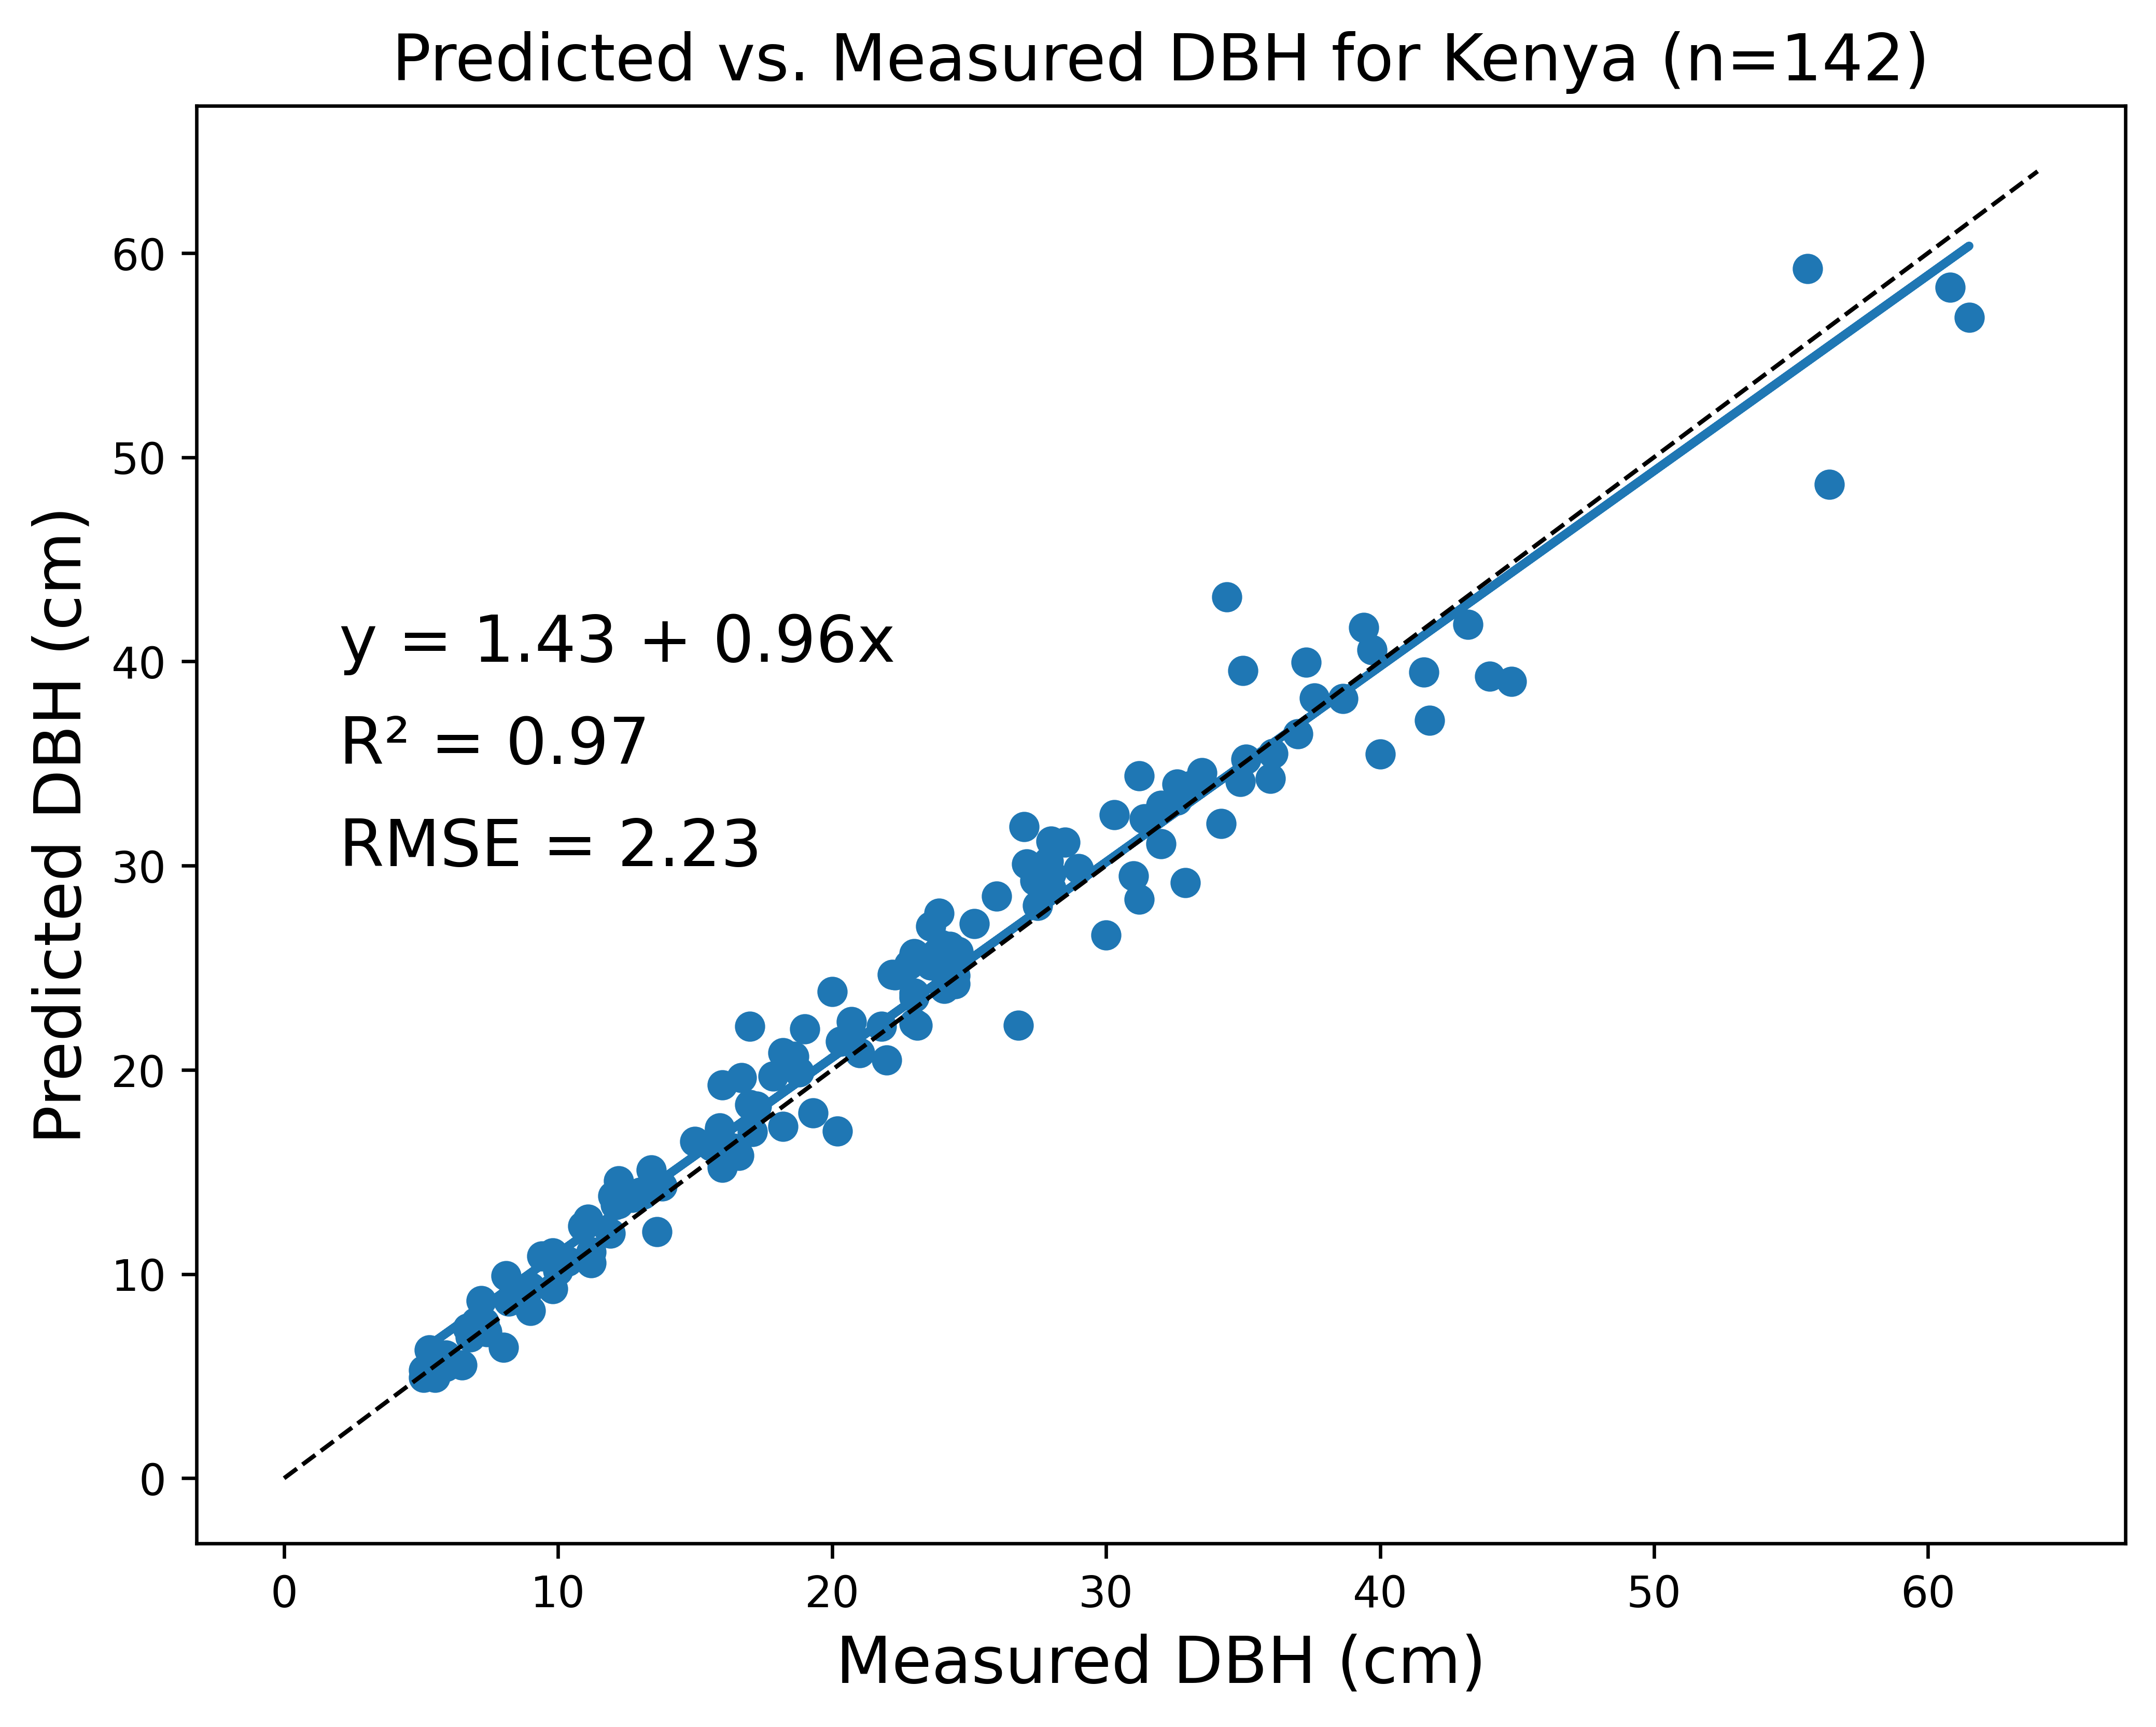

In [20]:

combined_data1 = combined_data[combined_data['source'] == 'kenya']

actual = combined_data1['measured_dbh']
predicted = combined_data1['predicted_dbh']
rmse = np.sqrt(mean_squared_error(actual, predicted))
rmse

# make residual plot for the corelation between predicted and measure dbh values
x = np.array(combined_data1['measured_dbh']); y = np.array( [ float(x) for x in combined_data1['predicted_dbh']])
a, b = np.polyfit(x, y , 1)

figure(figsize=(8, 6), dpi=600)


plt.scatter(x, y)
plt.plot(x, a*x+b,  linewidth=2)
plt.plot(np.arange(65), np.arange(65), color='black', linestyle='--', linewidth=1)
plt.xlabel("Measured DBH (cm)",  size=15)
plt.ylabel("Predicted DBH (cm)",  size=15)
plt.title(f"Predicted vs. Measured DBH for Kenya (n={len(combined_data1)})", size=15)

# add fitted regression equation to plot
plt.text(2, 40, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=15)

# add the r2
plt.text(2,35, f"R\u00b2 = {round(r2_score(x,y),2)} ", size=15)

# add rmse
plt.text(2,30, f"RMSE = {round(rmse,2)} ", size=15)

# get the regression line and coefficients p value anc confidence interval
import statsmodels.api as sm
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
model.summary()

Text(2, 30, 'RMSE = 2.2 ')

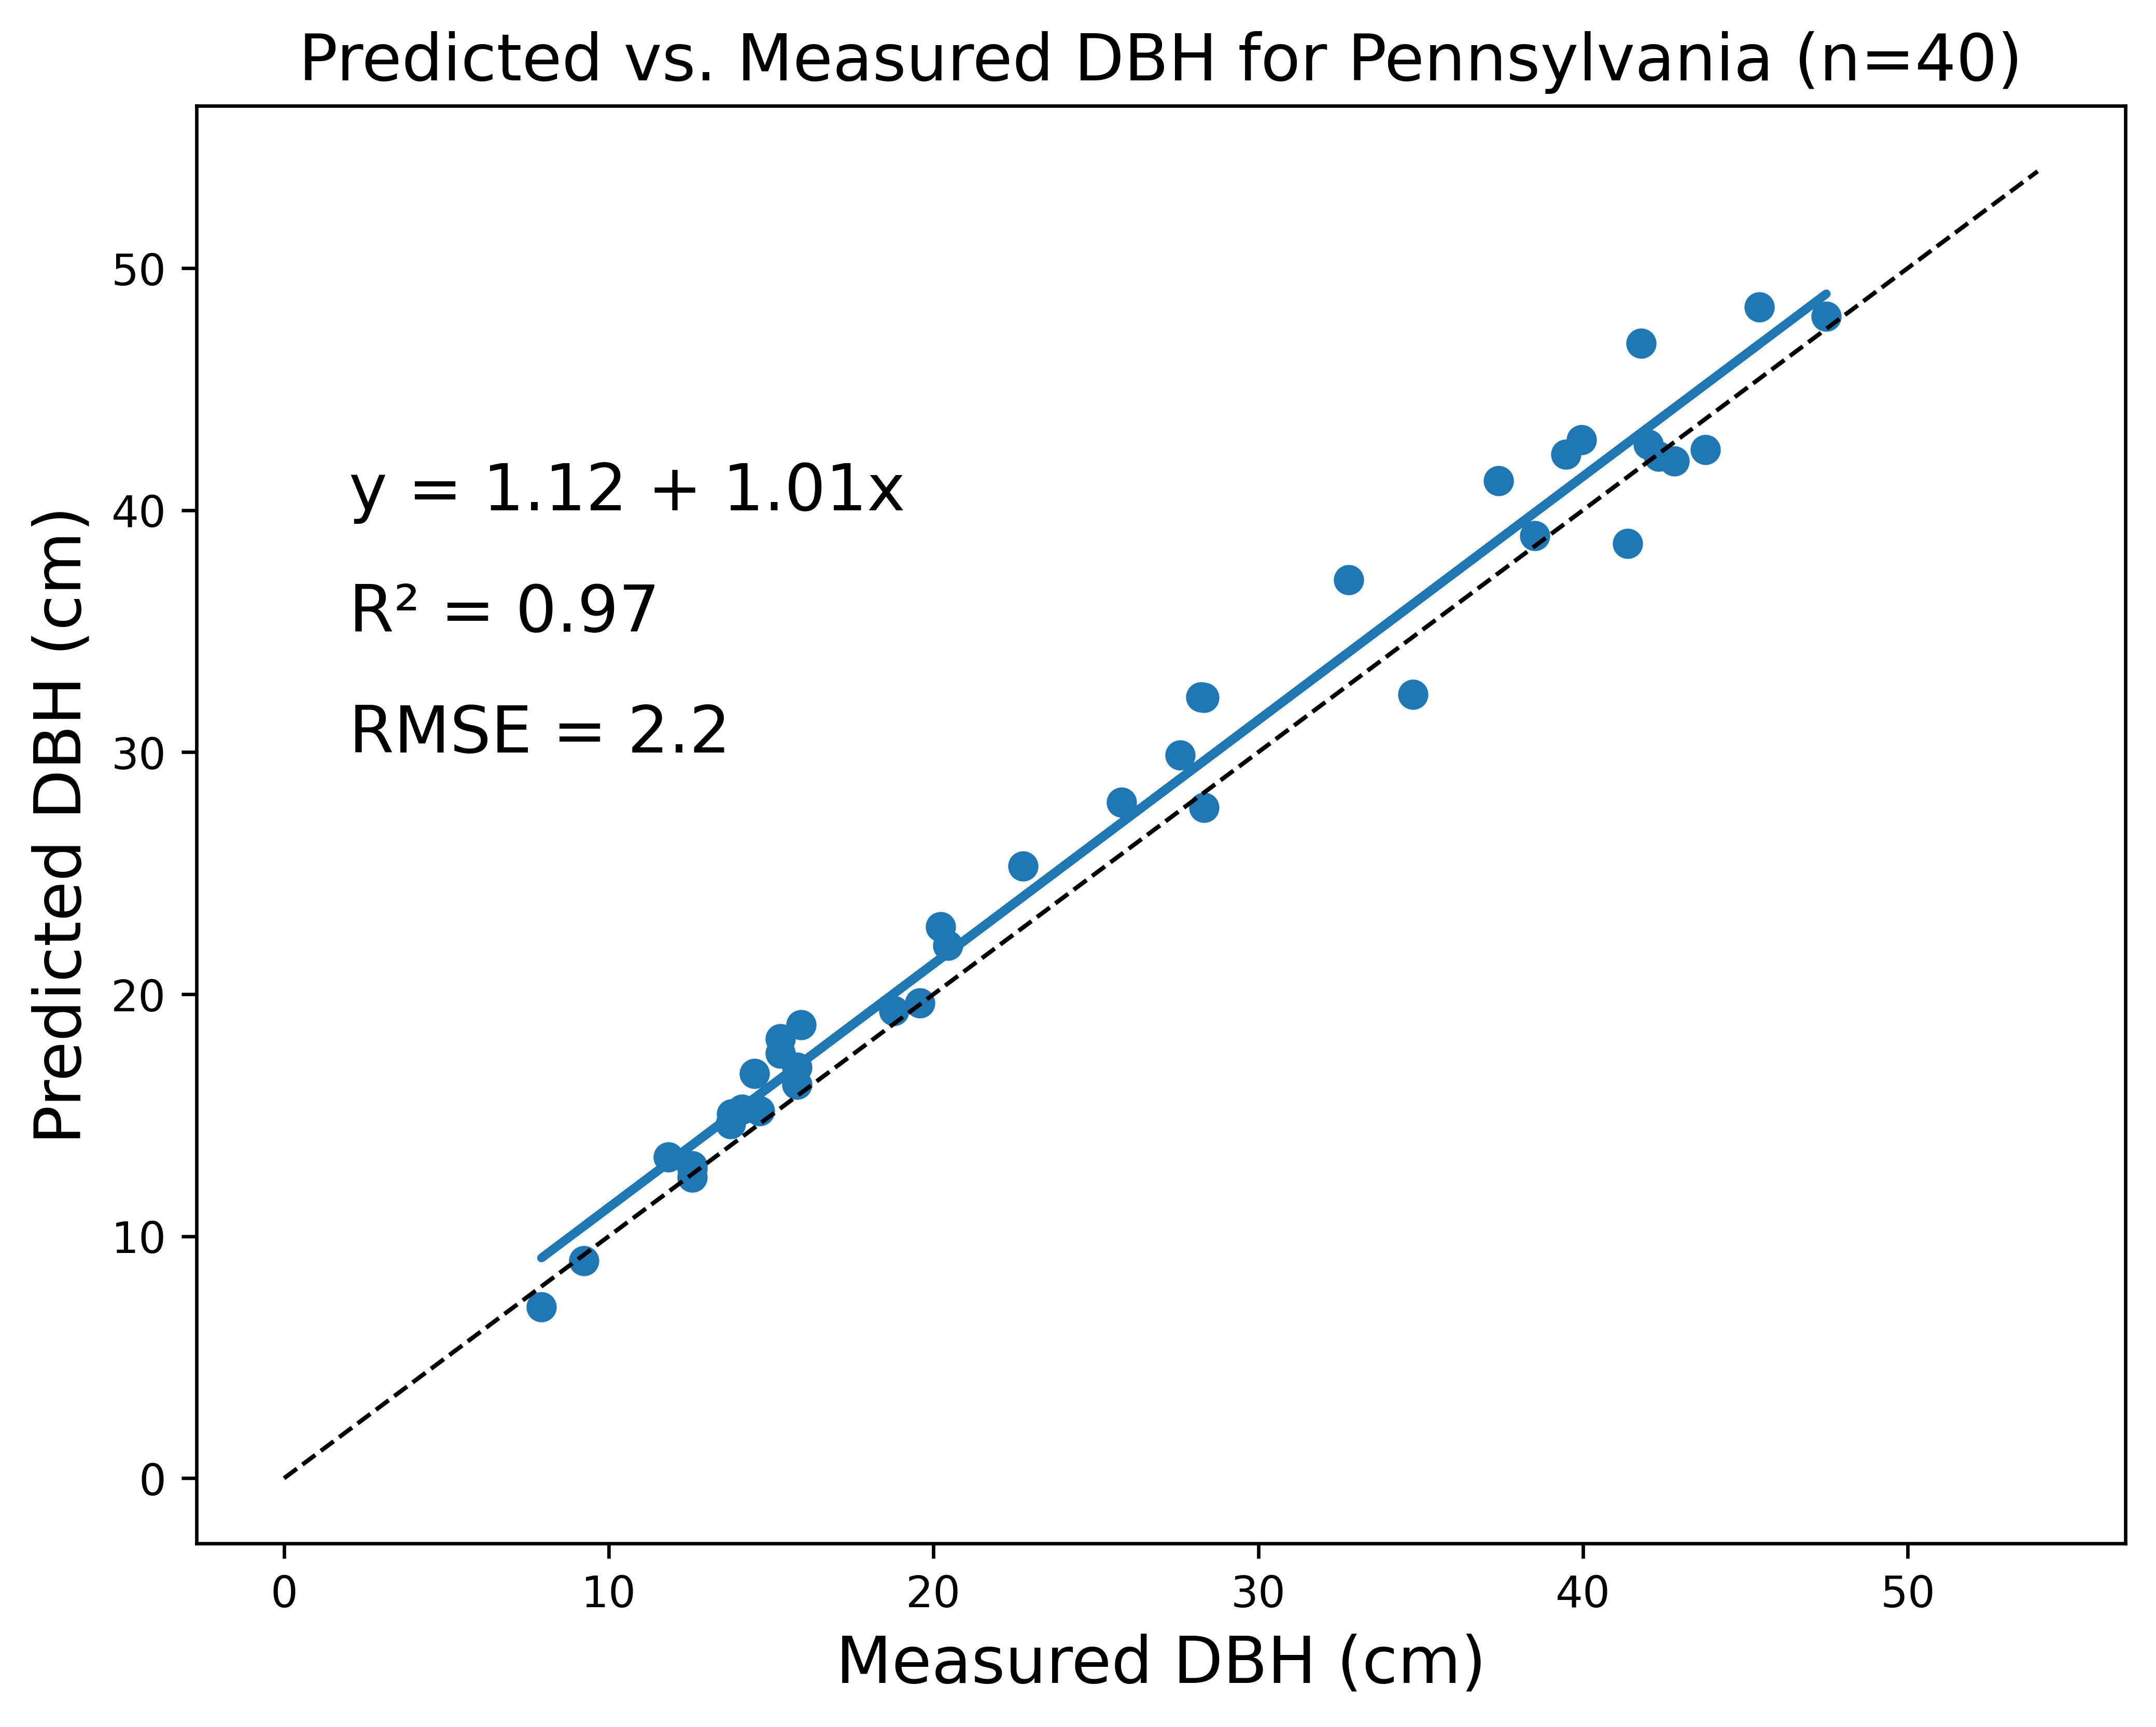

In [35]:
### accuracy for just the pennsylvania data ####

combined_data2 = combined_data[combined_data['source'] == 'pennsylvania']

actual = combined_data2['measured_dbh']
predicted = combined_data2['predicted_dbh']
rmse = np.sqrt(mean_squared_error(actual, predicted))
rmse
# make residual plot for the corelation between predicted and measure dbh values
x = np.array(combined_data2['measured_dbh']); y = np.array( [ float(x) for x in combined_data2['predicted_dbh']])
a, b = np.polyfit(x, y , 1)

figure(figsize=(8, 6), dpi=600)


plt.scatter(x, y)
plt.plot(x, a*x+b,  linewidth=2)
plt.plot(np.arange(55), np.arange(55), color='black', linestyle='--', linewidth=1)
plt.xlabel("Measured DBH (cm)",  size=15)
plt.ylabel("Predicted DBH (cm)",  size=15)
plt.title(f"Predicted vs. Measured DBH for Pennsylvania (n={len(combined_data2)})", size=15)

# add fitted regression equation to plot
plt.text(2, 40, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=15)

# add the r2
plt.text(2,35, f"R\u00b2 = {round(r2_score(x,y),2)} ", size=15)

# add rmse
plt.text(2,30, f"RMSE = {round(rmse,2)} ", size=15)

In [37]:
combined_data2['measured_dbh'].describe()

count    40.000000
mean     25.636678
std      12.409309
min       7.925916
25%      14.602466
50%      21.597326
75%      38.754229
max      47.491835
Name: measured_dbh, dtype: float64

In [39]:
np.mean(combined_data1['bias'].tolist()), np.std(combined_data1['bias'].tolist())

(0.5095774647887323, 2.1742992632691407)

In [40]:
np.mean(combined_data2['bias'].tolist()), np.std(combined_data2['bias'].tolist())

(1.2960717667574984, 1.7813798226404536)

In [106]:
np.mean(combined_data1['rel_bias'].tolist())

3.3659794203819944

In [107]:
np.mean(combined_data2['rel_bias'].tolist())

5.653131144482606

In [119]:
np.mean(combined_data['bias'].tolist())

0.6824333553313183

In [120]:
np.mean(combined_data['rel_bias'].tolist())

3.868650128975536

In [110]:
combined_data2[['bias', 'dbh_range']].groupby('dbh_range').mean()['bias']

dbh_range
05.0-15.9    1.027649
16.0-25.9    1.572205
26.0-35.9    1.928988
36+          1.199445
Name: bias, dtype: float64

In [111]:
combined_data1[['bias', 'dbh_range']].groupby('dbh_range').mean()['bias']

dbh_range
05.0-15.9    0.464694
16.0-25.9    1.144773
26.0-35.9    0.988710
36+         -1.746111
Name: bias, dtype: float64

In [118]:
combined_data[['bias', 'dbh_range']].groupby('dbh_range').count()

,bias
dbh_range,
05.0-15.9,65
16.0-25.9,50
26.0-35.9,37
36+,30


In [112]:
combined_data[['bias', 'dbh_range']].groupby('dbh_range').mean()['bias']

dbh_range
05.0-15.9    0.603267
16.0-25.9    1.196065
26.0-35.9    1.141187
36+         -0.567889
Name: bias, dtype: float64

In [113]:
combined_data[['rel_bias', 'dbh_range']].groupby('dbh_range').mean()['rel_bias']

dbh_range
05.0-15.9    4.620969
16.0-25.9    5.797731
26.0-35.9    3.890567
36+         -1.003541
Name: rel_bias, dtype: float64

In [114]:
combined_data1[['rel_bias', 'dbh_range']].groupby('dbh_range').mean()['rel_bias']

dbh_range
05.0-15.9    3.952203
16.0-25.9    5.608609
26.0-35.9    3.334228
36+         -3.657153
Name: rel_bias, dtype: float64

In [122]:
np.mean(combined_data1['rel_bias'].tolist())

3.3659794203819944

In [124]:
combined_data1[['bias', 'dbh_range']].groupby('dbh_range').mean()['bias']

dbh_range
05.0-15.9    0.464694
16.0-25.9    1.144773
26.0-35.9    0.988710
36+         -1.746111
Name: bias, dtype: float64

In [125]:
np.mean(combined_data1['bias'].tolist())

0.5095774647887323

In [126]:
combined_data1.groupby('dbh_range').count()

,source,measured_dbh,predicted_dbh,bias,rel_bias
dbh_range,,,,,
05.0-15.9,49,49,49,49,49
16.0-25.9,44,44,44,44,44
26.0-35.9,31,31,31,31,31
36+,18,18,18,18,18


In [115]:
combined_data2[['rel_bias', 'dbh_range']].groupby('dbh_range').mean()['rel_bias']

dbh_range
05.0-15.9    6.669065
16.0-25.9    7.184625
26.0-35.9    6.764986
36+          2.976878
Name: rel_bias, dtype: float64

In [127]:
np.mean(combined_data2['rel_bias'].tolist())

5.653131144482606

In [128]:
combined_data2[['bias', 'dbh_range']].groupby('dbh_range').mean()['bias']

dbh_range
05.0-15.9    1.027649
16.0-25.9    1.572205
26.0-35.9    1.928988
36+          1.199445
Name: bias, dtype: float64

In [129]:
np.mean(combined_data2['bias'].tolist())

1.2960717667574984

In [130]:
combined_data2.groupby('dbh_range').count()

,source,measured_dbh,predicted_dbh,bias,rel_bias
dbh_range,,,,,
05.0-15.9,16,16,16,16,16
16.0-25.9,6,6,6,6,6
26.0-35.9,6,6,6,6,6
36+,12,12,12,12,12


In [135]:
#  test statistical significance of the difference in bias between the two datasets

from scipy.stats import ttest_ind

ttest_ind(combined_data1['bias'], combined_data2['bias'])

TtestResult(statistic=-2.0864176175288094, pvalue=0.03835011168561118, df=180.0)

In [136]:
# test statistical significance of the difference in relative bias between the two datasets

ttest_ind(combined_data1['rel_bias'], combined_data2['rel_bias'])

TtestResult(statistic=-1.455338122342354, pvalue=0.1473174656838168, df=180.0)

<Axes: >

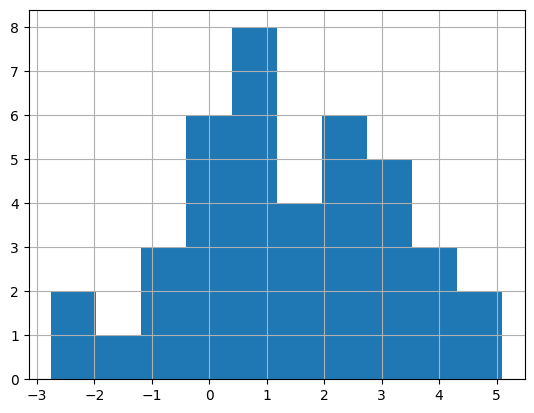

In [41]:
combined_data2['bias'].hist()

<Axes: >

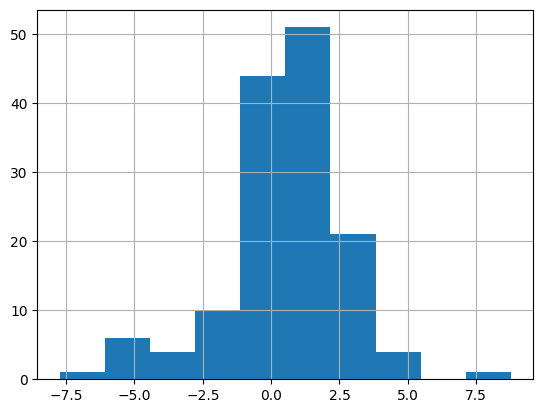

In [42]:
combined_data1['bias'].hist()

In [44]:
range1 = combined_data[combined_data['dbh_range'] == '05.0-15.9']  
range2 = combined_data[combined_data['dbh_range'] == '16.0-25.9']
range3 = combined_data[combined_data['dbh_range'] == '26.0-35.9']
range4 = combined_data[combined_data['dbh_range'] == '36+']

# anova test for bias
from scipy.stats import f_oneway

f_oneway(range1['bias'], range2['bias'], range3['bias'], range4['bias'])



F_onewayResult(statistic=5.407309449740567, pvalue=0.0013903187693194616)

In [61]:
f_oneway(range1['rel_bias'], range2['rel_bias'], range3['rel_bias'], range4['rel_bias'])

F_onewayResult(statistic=4.234134379599, pvalue=0.0064116430932697885)

In [59]:
## perform a post hoc for the range1 2, 3, and 4

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(combined_data['bias'], combined_data['dbh_range'])
result = mc.tukeyhsd()
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
05.0-15.9,16.0-25.9,0.5928,0.4182,-0.4081,1.5937,False
05.0-15.9,26.0-35.9,0.5379,0.5812,-0.5579,1.6337,False
05.0-15.9,36+,-1.1712,0.0509,-2.3456,0.0033,False
16.0-25.9,26.0-35.9,-0.0549,0.9993,-1.2088,1.099,False
16.0-25.9,36+,-1.764,0.0015,-2.9928,-0.5351,True
26.0-35.9,36+,-1.7091,0.0047,-3.0163,-0.4018,True


In [62]:
mc = MultiComparison(combined_data['rel_bias'], combined_data['dbh_range'])
result = mc.tukeyhsd()
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
05.0-15.9,16.0-25.9,1.1768,0.8853,-3.0088,5.3623,False
05.0-15.9,26.0-35.9,-0.7304,0.9761,-5.3128,3.852,False
05.0-15.9,36+,-5.6245,0.0177,-10.5358,-0.7133,True
16.0-25.9,26.0-35.9,-1.9072,0.735,-6.7324,2.9181,False
16.0-25.9,36+,-6.8013,0.0041,-11.9399,-1.6626,True
26.0-35.9,36+,-4.8941,0.0969,-10.3608,0.5726,False


Text(1, 6, 'A')

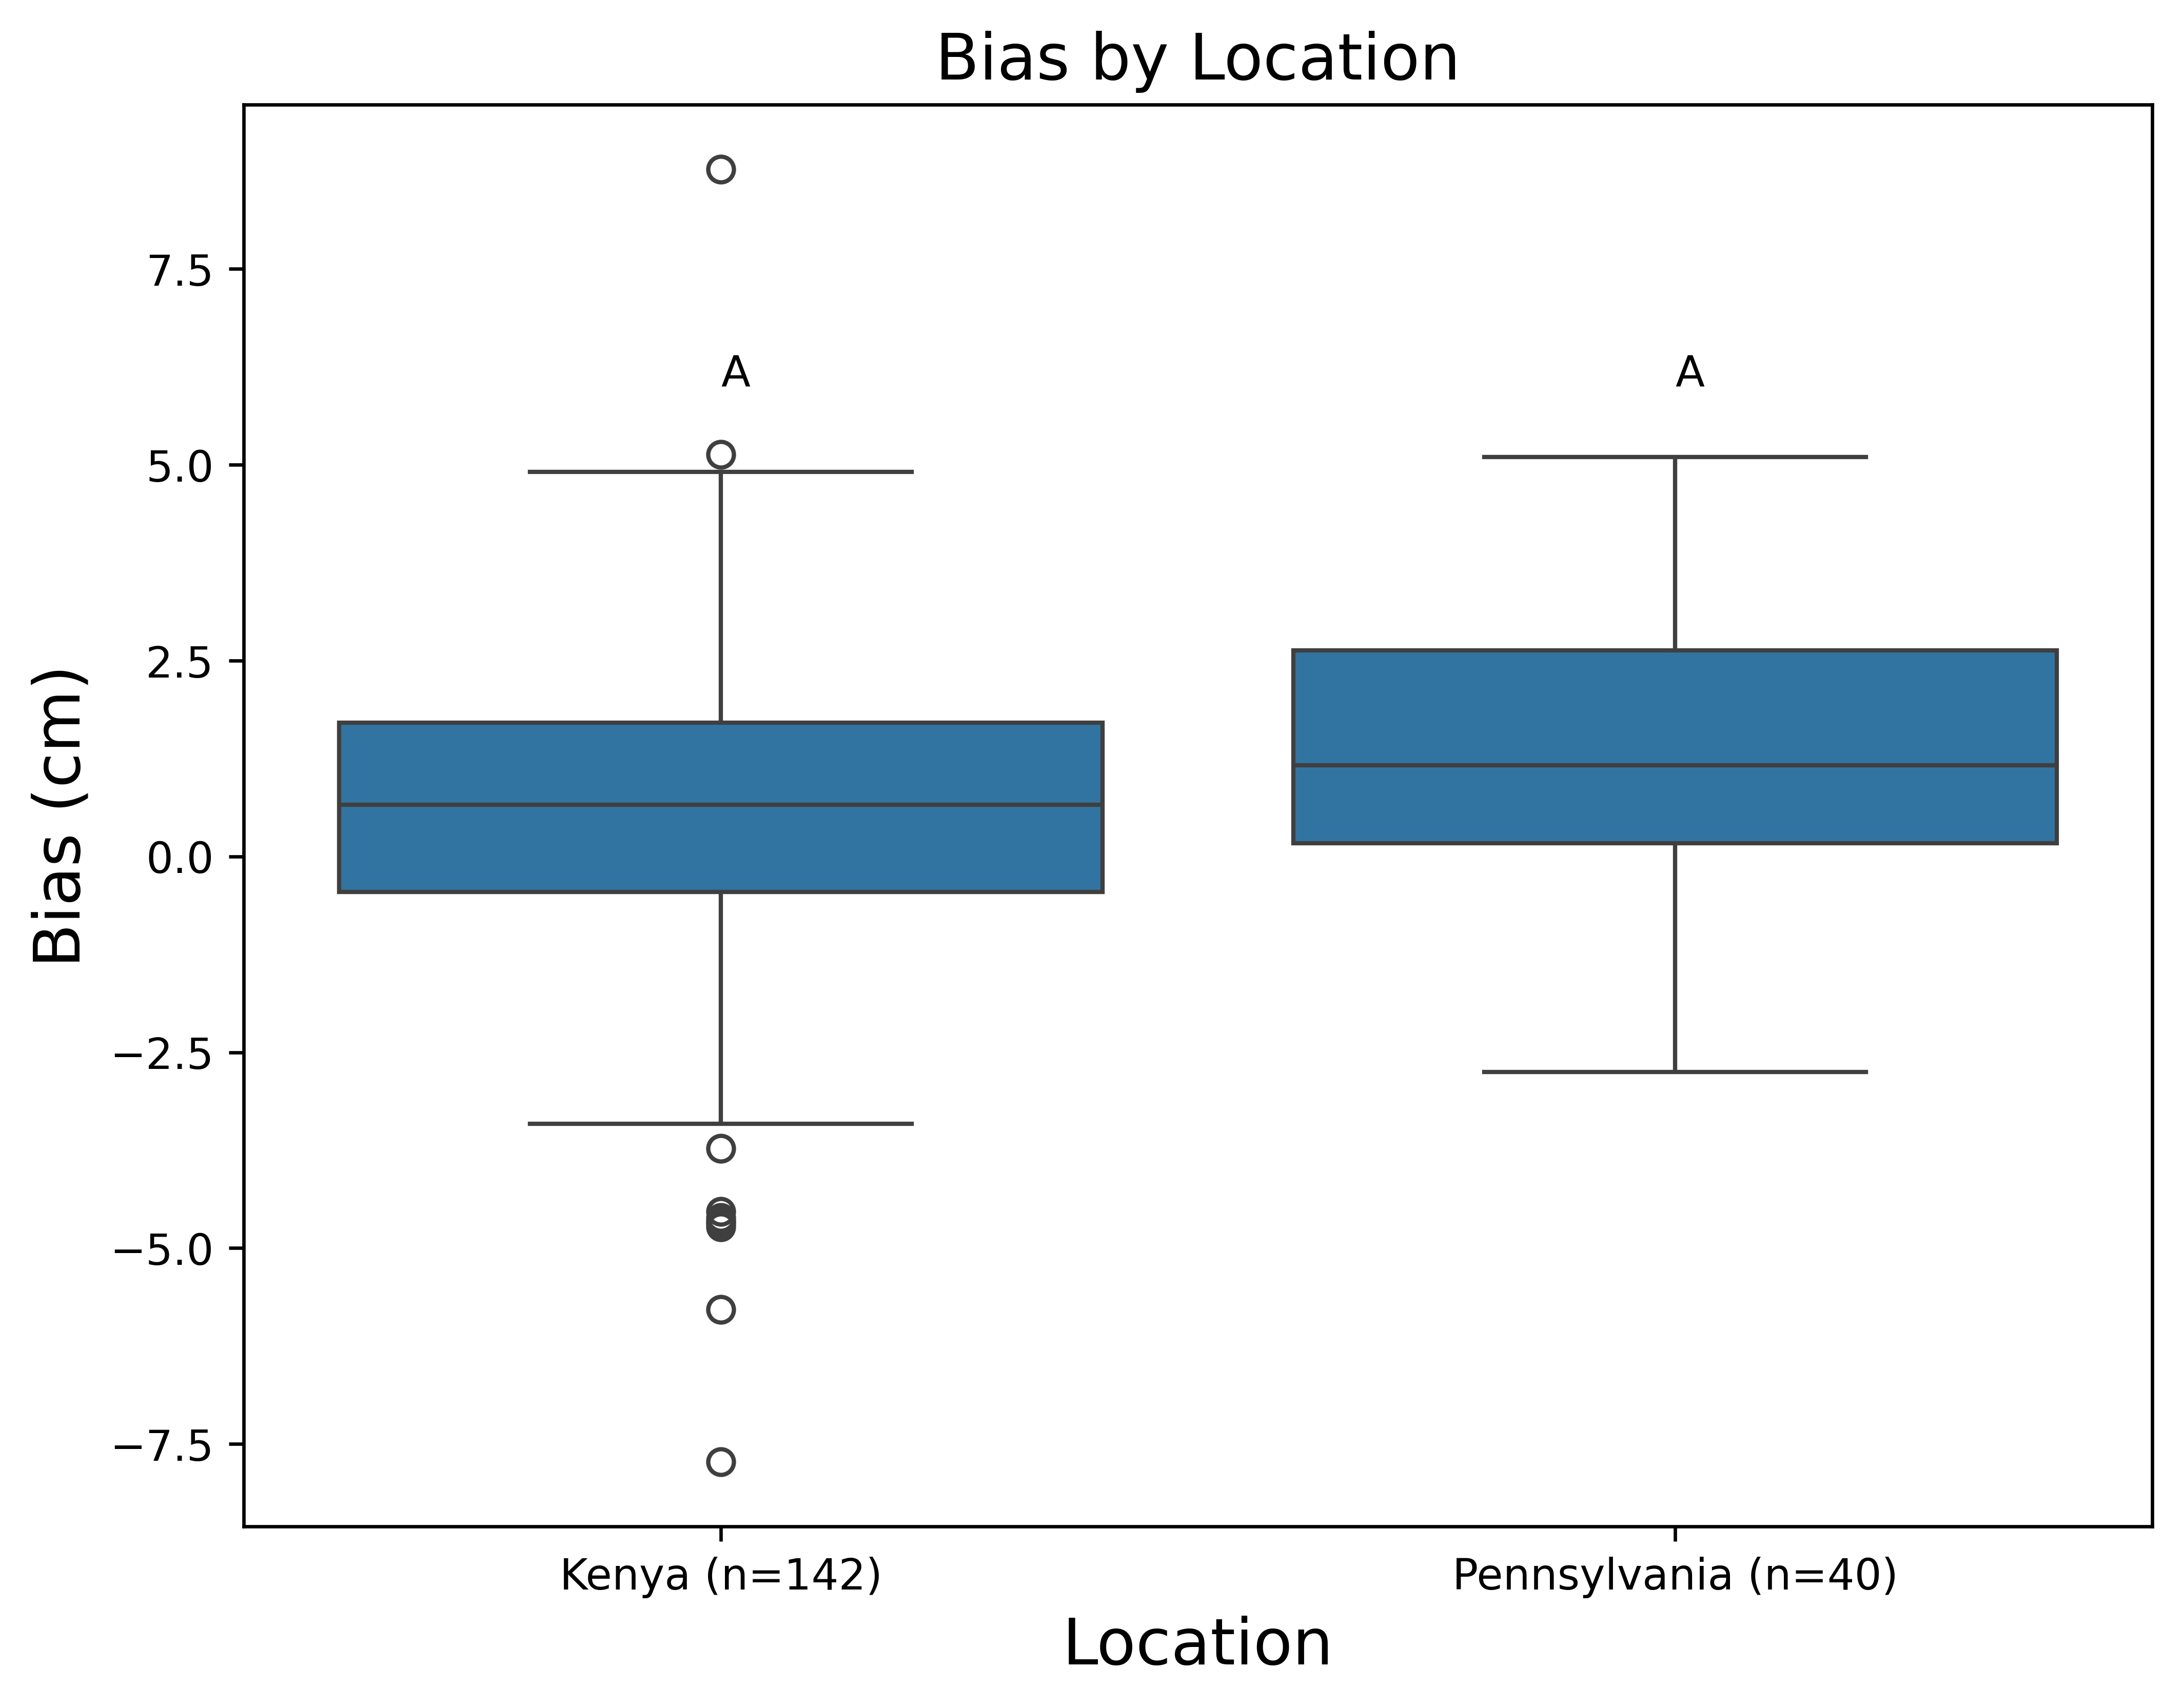

In [52]:
# box plot showing bias for kenya and pennsylvania separately
figure(figsize=(8, 6), dpi=600)
sns.boxplot(x="source", y="bias", data=combined_data)
plt.xlabel("Location", size=15)
plt.ylabel("Bias (cm)", size=15)
plt.title("Bias by Location", size=15)

# add sample number to the boxplot
plt.xticks([0,1], ['Kenya (n=142)','Pennsylvania (n=40)'])

# put text on the boxplot
plt.text(0,6, "A")
plt.text(1,6, "A")

Text(0.5, 1.0, 'Residuals vs Measured DBH (n=182)')

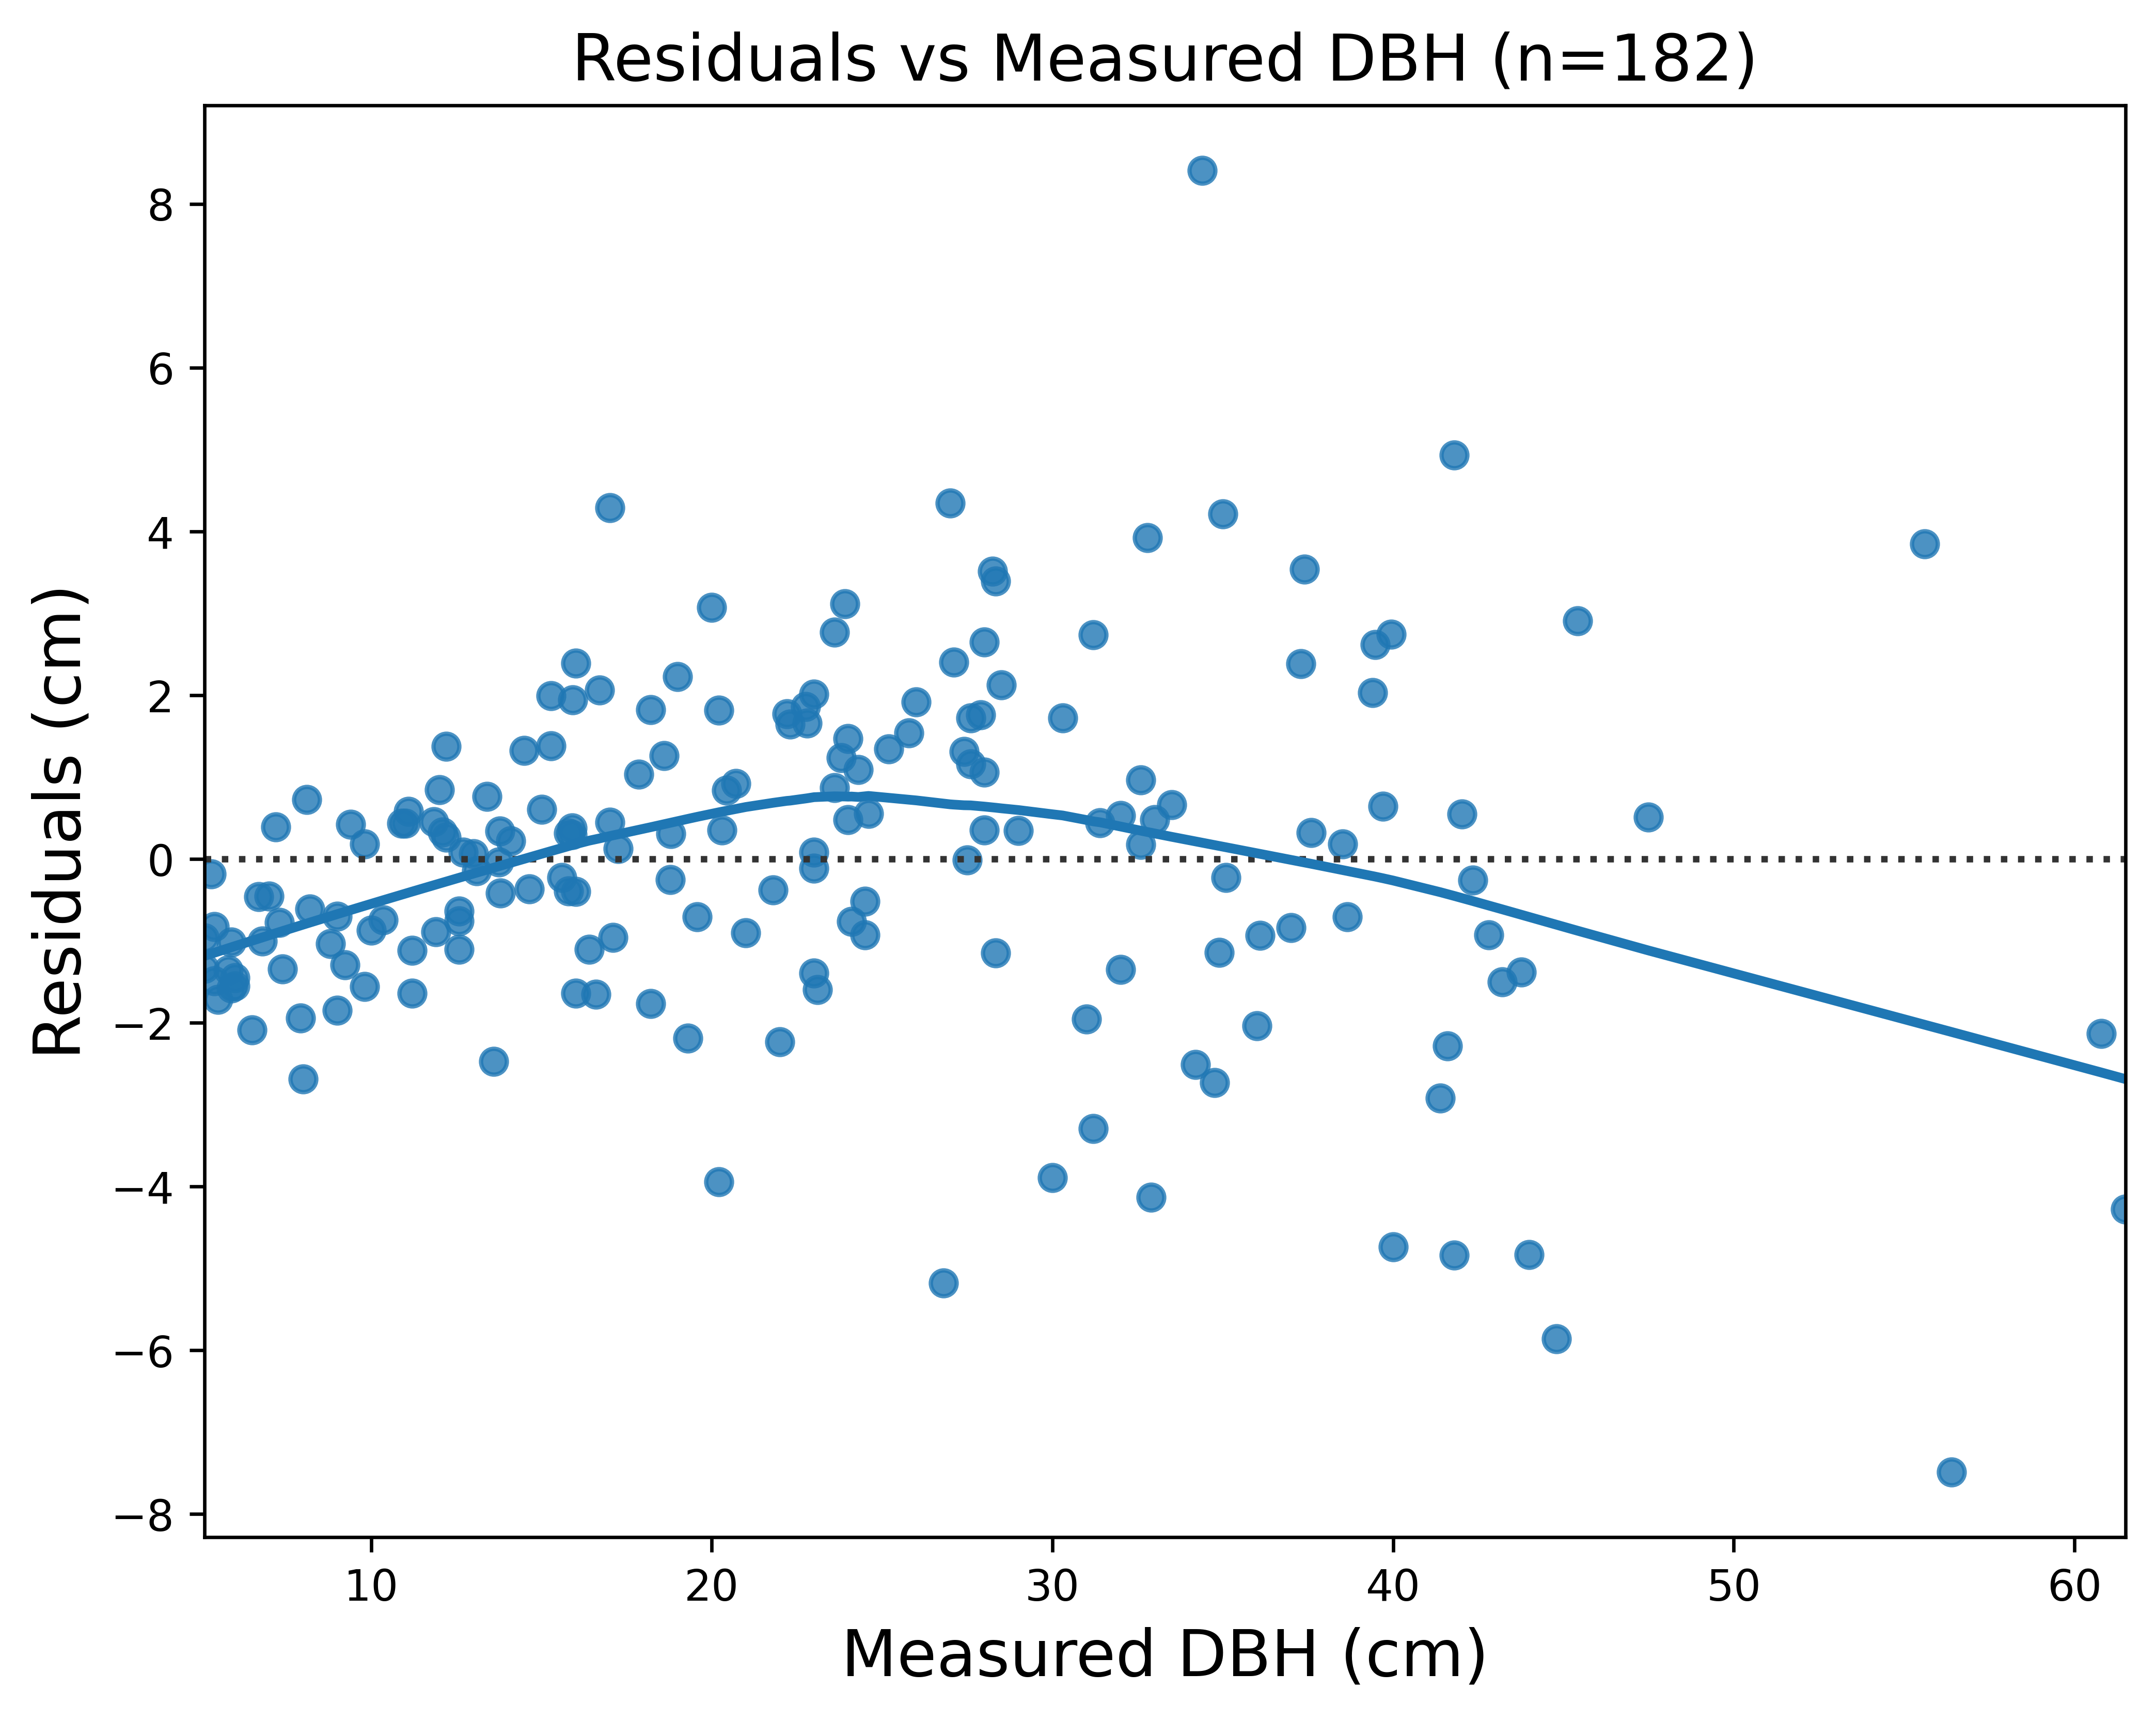

In [15]:
## residual plot 
figure(figsize=(8, 6), dpi=600)
sns.residplot(x="measured_dbh", y="predicted_dbh", data=combined_data, lowess=True)
plt.xlabel("Measured DBH (cm)", size=15)
plt.ylabel("Residuals (cm)", size=15)
plt.title("Residuals vs Measured DBH (n=182)", size=15)